# pyVDJ for fetal BM T cells

This tutorial is for pyVDJ v0.1.1. The package is available here: https://github.com/veghp/pyVDJ

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import scanpy as sc  
import pyvdj
import upsetplot

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
sc.settings.set_figure_params(dpi=300, dpi_save=1000)

In [3]:
adata = sc.read("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/figs3f_tcell_dr_20200718.h5ad")

In [4]:
adata.shape

(560, 33712)

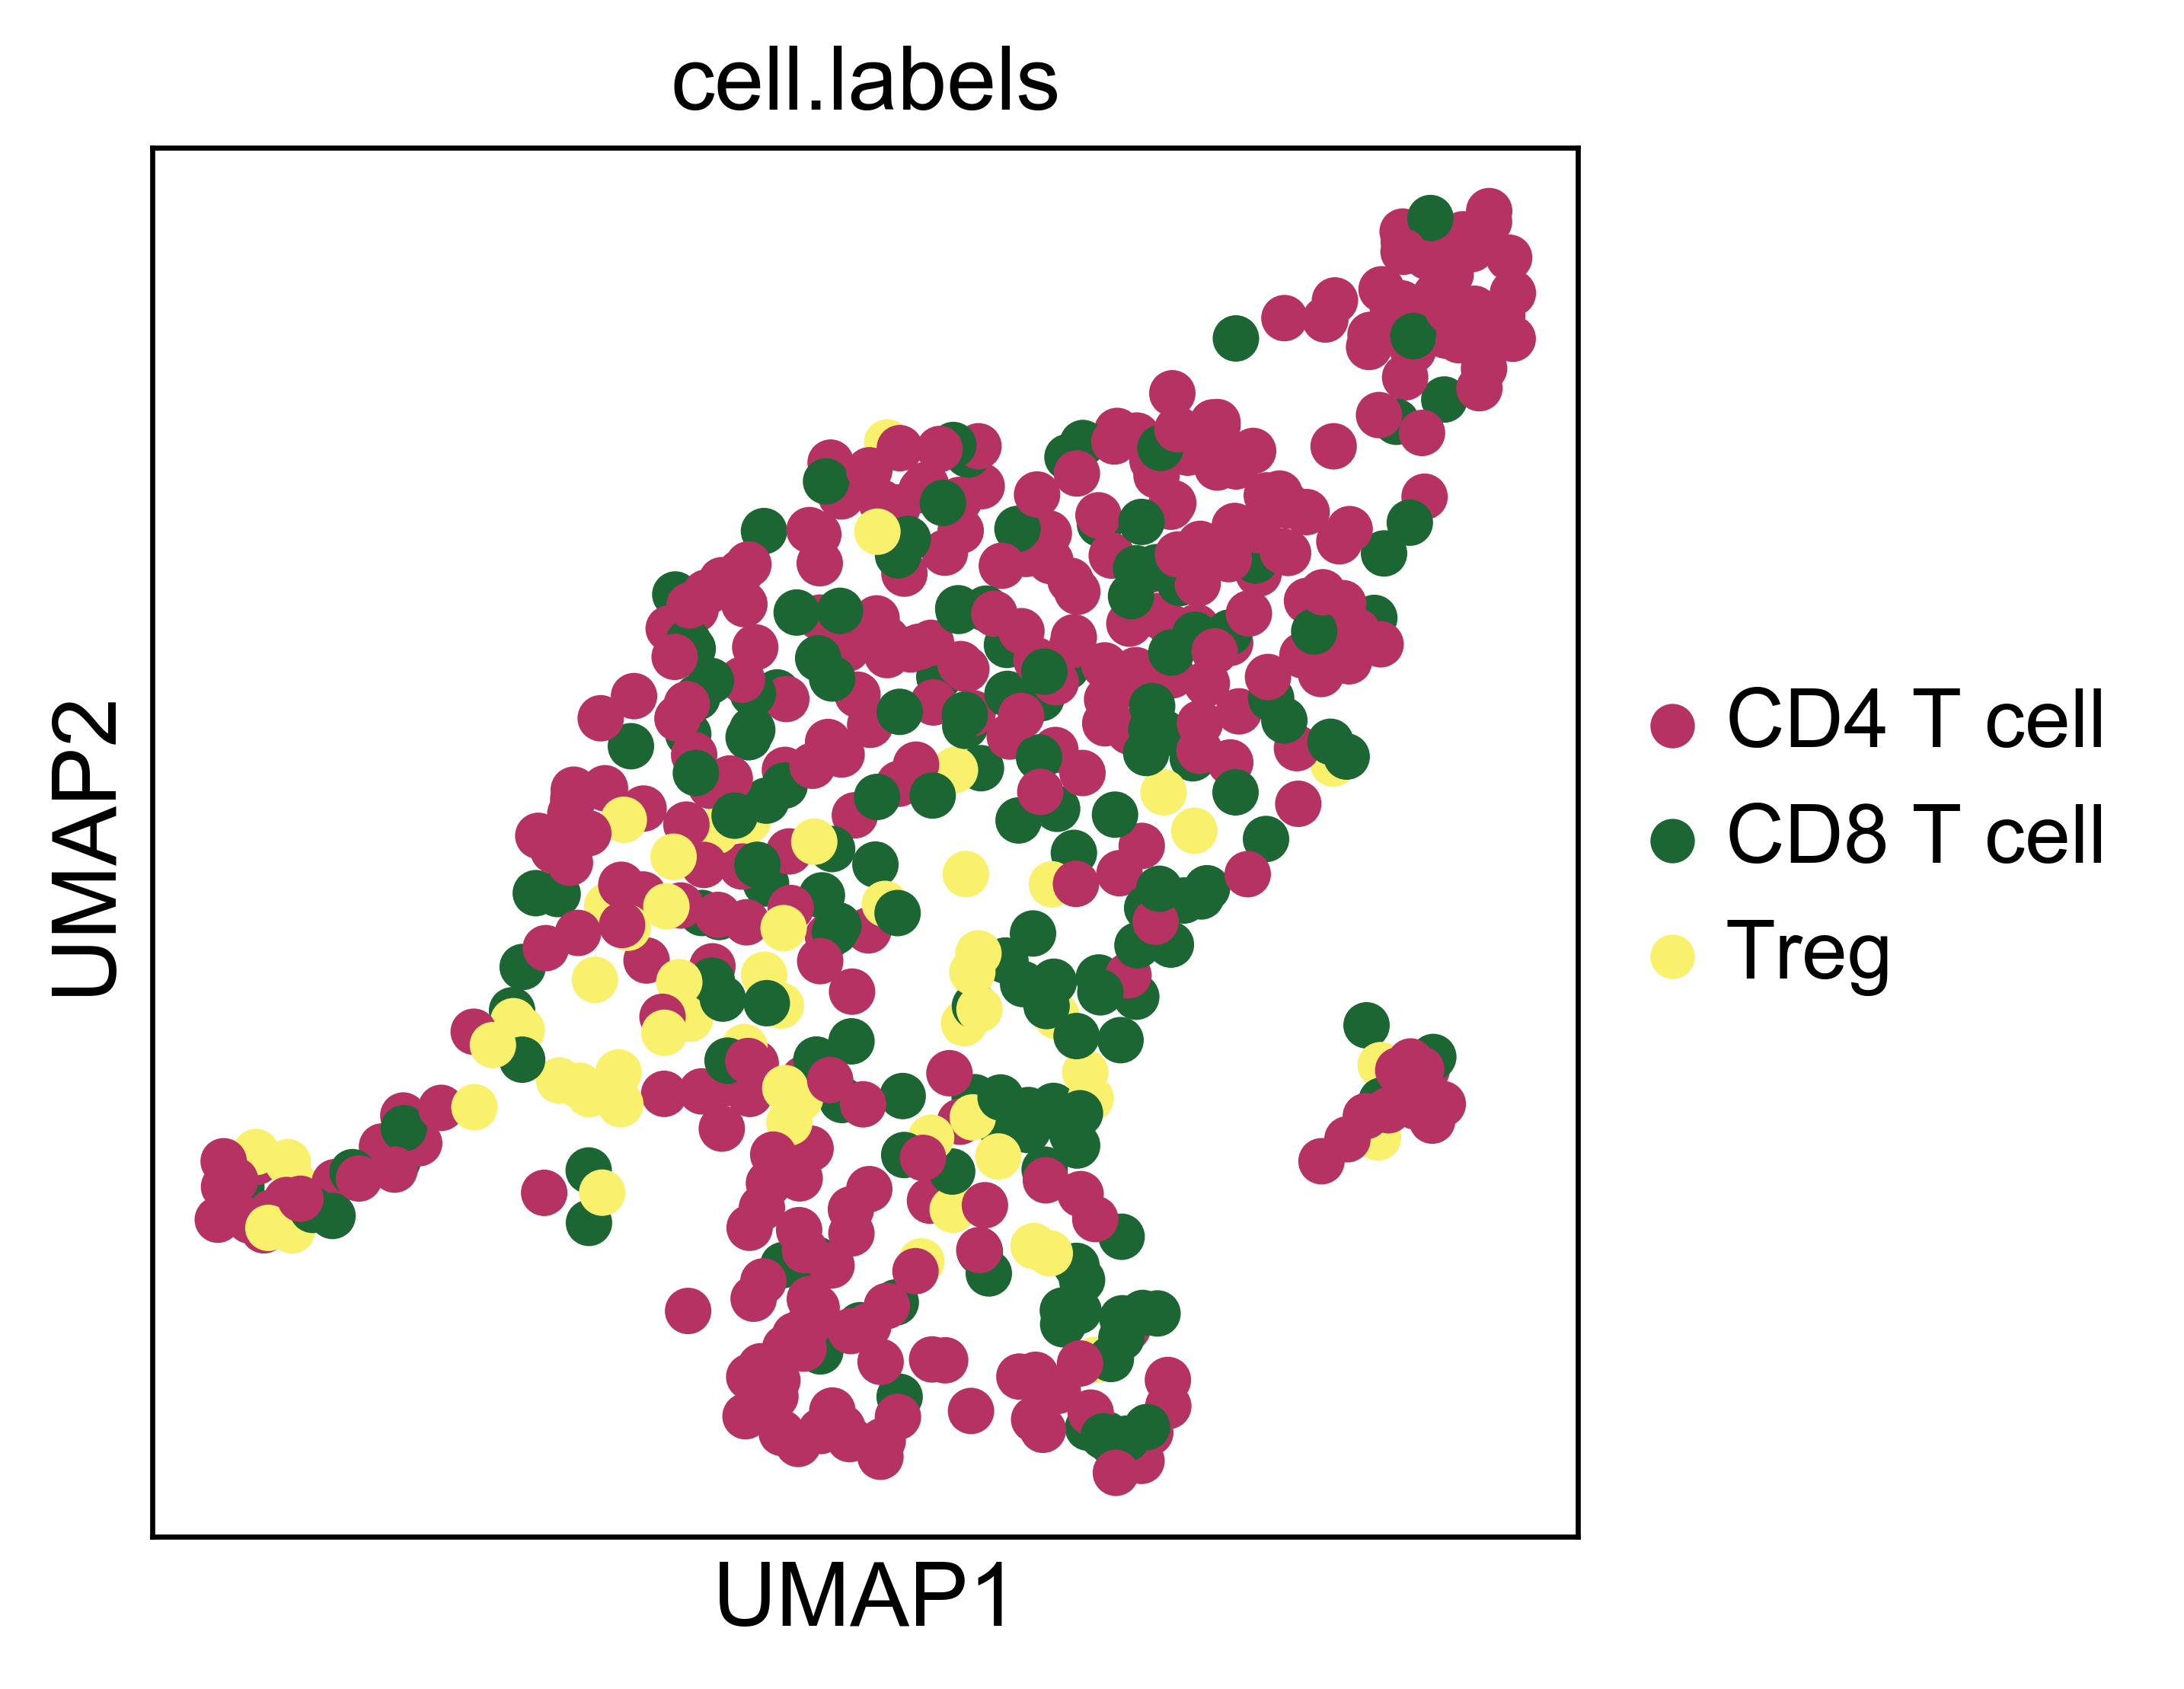

In [5]:
sc.pl.umap(adata, color=['cell.labels'])

In [6]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CD4 T cell    327
CD8 T cell    171
Treg           62
dtype: int64

In [7]:
adata = adata[adata.obs['orig.ident'].isin(['F50', 'F51'])].copy()

In [8]:
adata.shape

(181, 33712)

In [9]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CD4 T cell    77
CD8 T cell    76
Treg          28
dtype: int64

Our example dataset contains T and B lymphocytes:

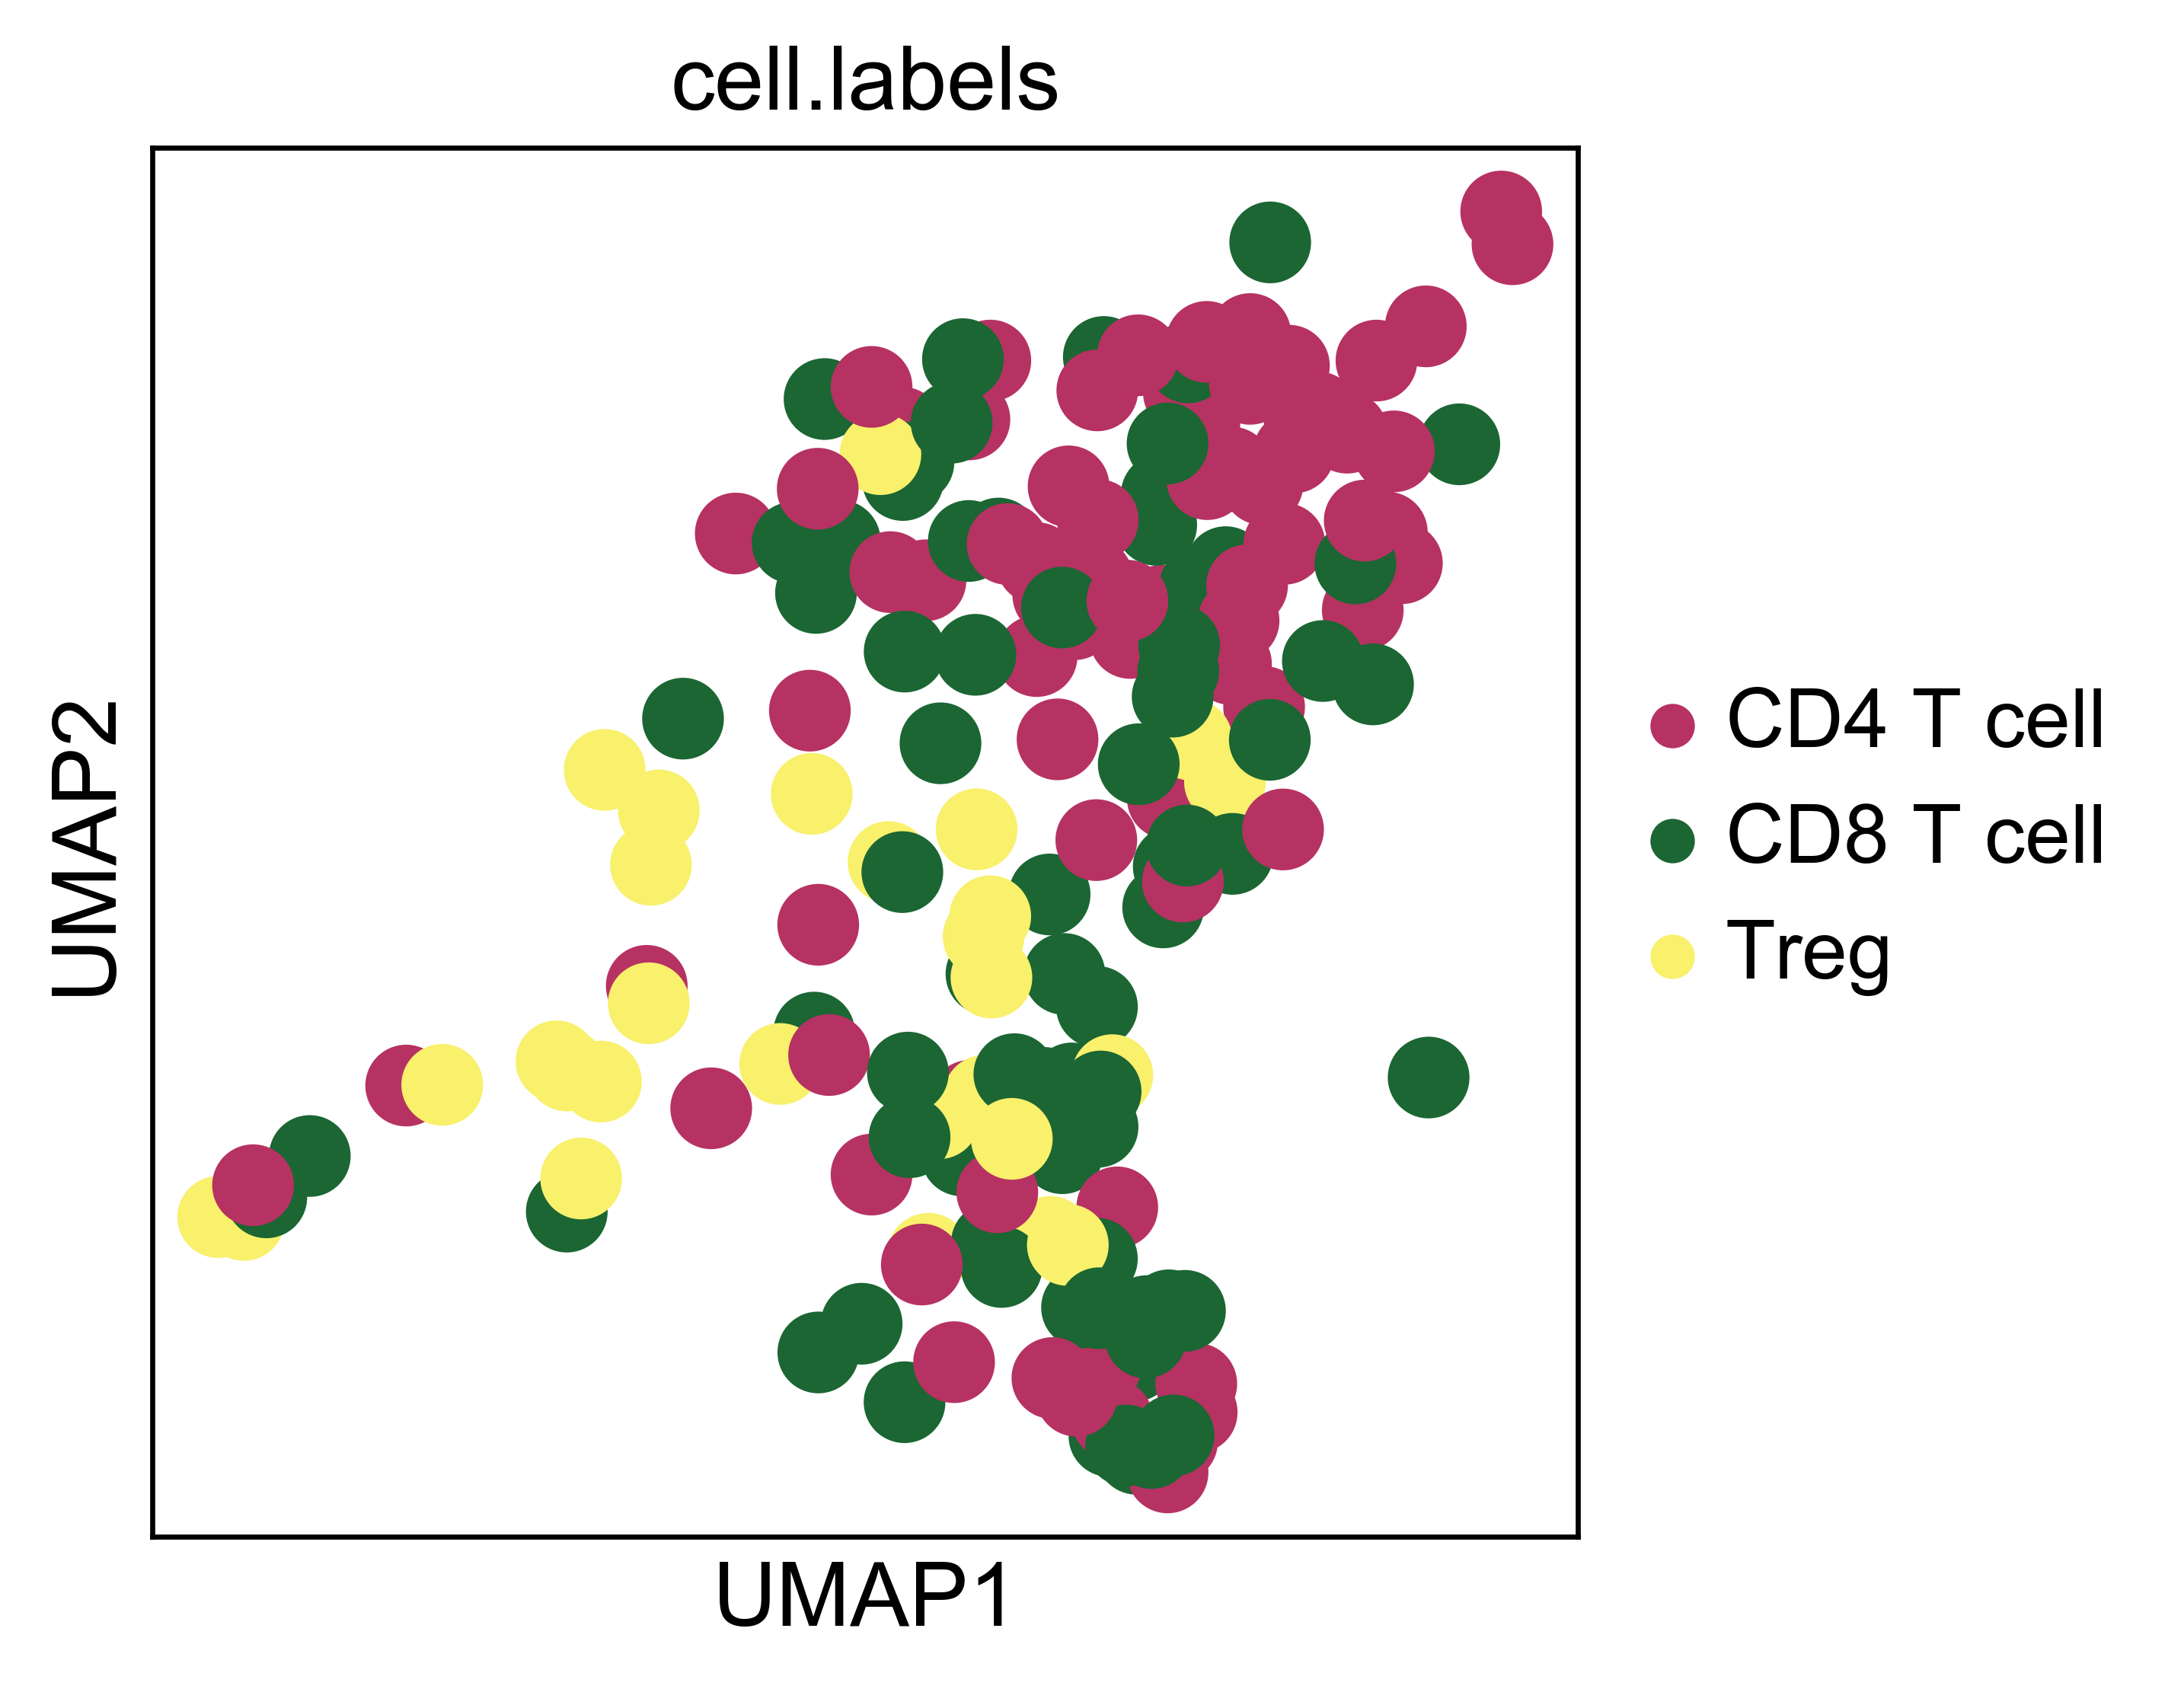

In [10]:
sc.pl.umap(adata, color='cell.labels', use_raw=False)

# Load VDJ data

### Load the  VDJ data in (using a manifest to match to their GEX pair)

To load in the VDJ data, we construct filepaths and a dictionary linking files to sample names. The easiest way is to prepare a manifest that lists the GEX sample names next to the V(D)J 10x directory names in a csv file.

We have seven lanes of TCR enriched VDJ data and five lanes of BCR enriched VDJ data 

In [11]:
# set the path for the manifest/vdj_data_files and the columns for the T and B cell enrichment
adata_GEX_lanes_name = 'lanes'

manifest = pd.read_csv("/Users/b8058304/Documents/PhD_work/Coding/bm/figs/counts/10x_lane_info.csv")
manifest_GEX_lanes_col = 'SANGER.SAMPLE.IDs'
manifest_B_cell_enrichment_col = 'B_cell_enrichment'
manifest_T_cell_enrichment_col = 'T_cell_enrichment'

vdj_data_path = '/Users/b8058304/Documents/PhD_work/Coding/bm/data/vdj_data/'
vdj_figs_path = '/Users/b8058304/Documents/PhD_work/Coding/bm/figs/vdj/'

In [12]:
manifest = manifest[manifest[manifest_GEX_lanes_col].isin(adata.obs[adata_GEX_lanes_name].unique())]  # keep the ones in adata
manifest

SANGER.SAMPLE.IDs     SAMPLE.NAME       Organ Sequencing  Passed AnnatomicalPart T_cell_enrichment B_cell_enrichment
20    FCAImmP7803016  F50_BM_CD45P_5  boneMarrow       5GEX    True         unknown    FCAImmP7812643    FCAImmP7812647
21    FCAImmP7803017  F50_BM_CD45P_6  boneMarrow       5GEX    True         unknown    FCAImmP7812644    FCAImmP7812648
23    FCAImmP7803032  F51_BM_CD45N_2  boneMarrow       5GEX    True         unknown               NaN               NaN
25    FCAImmP7803028  F51_BM_CD45P_7  boneMarrow       5GEX    True         unknown    FCAImmP7812653    FCAImmP7812658
26    FCAImmP7803029  F51_BM_CD45P_8  boneMarrow       5GEX    True         unknown    FCAImmP7812654    FCAImmP7812659
27    FCAImmP7803030  F51_BM_CD45P_9  boneMarrow       5GEX    True         unknown    FCAImmP7812655    FCAImmP7812660

In [13]:
manifest = manifest[manifest[manifest_T_cell_enrichment_col].notnull()]  # can remove samples which have no VDJ (we have VDJ for all GEX)
# Construct paths to VDJ csv files:
paths = vdj_data_path + manifest[manifest_T_cell_enrichment_col] + '/filtered_contig_annotations.csv'
# Construct paths to VDJ csv files:
samples = dict(zip(paths, manifest[manifest_GEX_lanes_col]))
samples

{'/Users/b8058304/Documents/PhD_work/Coding/bm/data/vdj_data/FCAImmP7812643/filtered_contig_annotations.csv': 'FCAImmP7803016',
 '/Users/b8058304/Documents/PhD_work/Coding/bm/data/vdj_data/FCAImmP7812644/filtered_contig_annotations.csv': 'FCAImmP7803017',
 '/Users/b8058304/Documents/PhD_work/Coding/bm/data/vdj_data/FCAImmP7812653/filtered_contig_annotations.csv': 'FCAImmP7803028',
 '/Users/b8058304/Documents/PhD_work/Coding/bm/data/vdj_data/FCAImmP7812654/filtered_contig_annotations.csv': 'FCAImmP7803029',
 '/Users/b8058304/Documents/PhD_work/Coding/bm/data/vdj_data/FCAImmP7812655/filtered_contig_annotations.csv': 'FCAImmP7803030'}

##### Prepare metadata column in adata object

The AnnData object must contain a metadata column (e.g. `adata.obs['vdj_obs']`) of the following format: `cellbarcode + '_' + lane`. This can be constructed from the cell barcodes and lane names (provided that we have sample annotation):

We then read V(D)J data into the AnnData object and create annotations. Note that values in the `filtered_contig_annotations.csv` files cannot be directly added as annotations, because one cell may have 0 to n values per entry. It will be stored in `adata.uns` and annotation will be generated separately.

Also note that the nomenclature used for the barcodes in `adata.obs['vdj_obs']` slot must match the nomenclature used for barcodes stored in `adata.uns['pyvdj']['df']['barcode']` later on in this notebook

In [14]:
cellnames = adata.obs_names
cellnames

Index(['F50_boneMarrow_CD45+_FCAImmP7803017_5GEX_CTACACCCACATTTCT', 'F50_boneMarrow_CD45+_FCAImmP7803016_5GEX_AAACGGGAGATGCCAG', 'F50_boneMarrow_CD45+_FCAImmP7803016_5GEX_AAAGCAACACAGCGTC', 'F50_boneMarrow_CD45+_FCAImmP7803016_5GEX_AACTCCCTCGGTCCGA', 'F50_boneMarrow_CD45+_FCAImmP7803016_5GEX_ACTGATGTCTCTAGGA', 'F50_boneMarrow_CD45+_FCAImmP7803016_5GEX_AGAGCTTGTACAGCAG', 'F50_boneMarrow_CD45+_FCAImmP7803016_5GEX_AGCCTAACATGTAAGA', 'F50_boneMarrow_CD45+_FCAImmP7803016_5GEX_ATTACTCGTGCCTGCA', 'F50_boneMarrow_CD45+_FCAImmP7803016_5GEX_CAGTAACAGTTGAGTA', 'F50_boneMarrow_CD45+_FCAImmP7803016_5GEX_CCGTACTTCCCATTTA',
       ...
       'F51_boneMarrow_CD45+_FCAImmP7803030_5GEX_GTAACTGGTAAGTTCC', 'F51_boneMarrow_CD45+_FCAImmP7803030_5GEX_GTAGTCACACGAAAGC', 'F51_boneMarrow_CD45+_FCAImmP7803030_5GEX_GTGTTAGTCAACGGGA', 'F51_boneMarrow_CD45+_FCAImmP7803030_5GEX_TAGACCAGTCTAGAGG', 'F51_boneMarrow_CD45+_FCAImmP7803030_5GEX_TATCAGGGTATAGGGC', 'F51_boneMarrow_CD45+_FCAImmP7803030_5GEX_TCGTAGACACACCGAC',

In [15]:
cellnames = adata.obs_names
cellbarcode = cellnames.str.split("_").str[5:6].str.join("-") # cell barcode part + '-1'
adata.obs['vdj_obs'] = cellbarcode.astype(str) + "-1_" + adata.obs['lanes'].astype(str)

In [16]:
adata.obs['vdj_obs']

index
F50_boneMarrow_CD45+_FCAImmP7803017_5GEX_CTACACCCACATTTCT    CTACACCCACATTTCT-1_FCAImmP7803017
F50_boneMarrow_CD45+_FCAImmP7803016_5GEX_AAACGGGAGATGCCAG    AAACGGGAGATGCCAG-1_FCAImmP7803016
F50_boneMarrow_CD45+_FCAImmP7803016_5GEX_AAAGCAACACAGCGTC    AAAGCAACACAGCGTC-1_FCAImmP7803016
F50_boneMarrow_CD45+_FCAImmP7803016_5GEX_AACTCCCTCGGTCCGA    AACTCCCTCGGTCCGA-1_FCAImmP7803016
F50_boneMarrow_CD45+_FCAImmP7803016_5GEX_ACTGATGTCTCTAGGA    ACTGATGTCTCTAGGA-1_FCAImmP7803016
F50_boneMarrow_CD45+_FCAImmP7803016_5GEX_AGAGCTTGTACAGCAG    AGAGCTTGTACAGCAG-1_FCAImmP7803016
F50_boneMarrow_CD45+_FCAImmP7803016_5GEX_AGCCTAACATGTAAGA    AGCCTAACATGTAAGA-1_FCAImmP7803016
F50_boneMarrow_CD45+_FCAImmP7803016_5GEX_ATTACTCGTGCCTGCA    ATTACTCGTGCCTGCA-1_FCAImmP7803016
F50_boneMarrow_CD45+_FCAImmP7803016_5GEX_CAGTAACAGTTGAGTA    CAGTAACAGTTGAGTA-1_FCAImmP7803016
F50_boneMarrow_CD45+_FCAImmP7803016_5GEX_CCGTACTTCCCATTTA    CCGTACTTCCCATTTA-1_FCAImmP7803016
F50_boneMarrow_CD45+_FCAImmP7803016_5GEX_CGC

##### Load data

In [17]:
adata = pyvdj.load_vdj(samples, adata, obs_col='vdj_obs', cellranger=2)

In [18]:
adata.uns["pyvdj"]

{'df':                  barcode  is_cell                     contig_id  high_confidence  length  chain     v_gene d_gene   j_gene c_gene  full_length  productive              cdr3                                           cdr3_nt  reads  umis raw_clonotype_id        raw_consensus_id                       barcode_meta                 clonotype_replaced                                    clonotype_meta          sample  productive_all  productive_any
 0     AAACGGGAGATGCCAG-1     True   AAACGGGAGATGCCAG-1_contig_1             True     648    TRB   TRBV11-1  TRBD2  TRBJ2-7  TRBC2         True        True     CASSSGSSYEQYF           TGTGCCAGCAGCAGCGGGAGCTCCTACGAGCAGTACTTC    857    17       clonotype2  clonotype2_consensus_2  AAACGGGAGATGCCAG-1_FCAImmP7803016                         clonotype2                         clonotype2_FCAImmP7803016  FCAImmP7803016           False            True
 1     AAACGGGAGATGCCAG-1     True   AAACGGGAGATGCCAG-1_contig_2             True     623    IGL   IGL

In [19]:
len(adata.uns["pyvdj"]["df"]["clonotype_meta"].unique())

1050

This loaded 10x V(D)J sequencing data (i.e. filtered_contig_annotations.csv files) into adata.uns['pyvdj']. `obs_col` specifies the annotation column for cellnames, as prepared above. For Cell Ranger version 3, set the parameter to 3.
For definitions of some words (clone, clonotype etc) used in the next section, see https://github.com/veghp/pyVDJ.

## VDJ annotation - clonotype and productivity

In [20]:
adata = pyvdj.add_obs(adata, obs=['clonotype', 'is_clone'])

This generates annotation in `adata.obs`. Now we can plot V(D)J properties:

This will show whether we have VDJ data for a cell we have captured in the GEX. It will also show if that cell is a clone (a cell whose TCR is identical to another cell, within the same individual (donor, organism)) and if it is productive (produces a TCR/BCR at protein level)

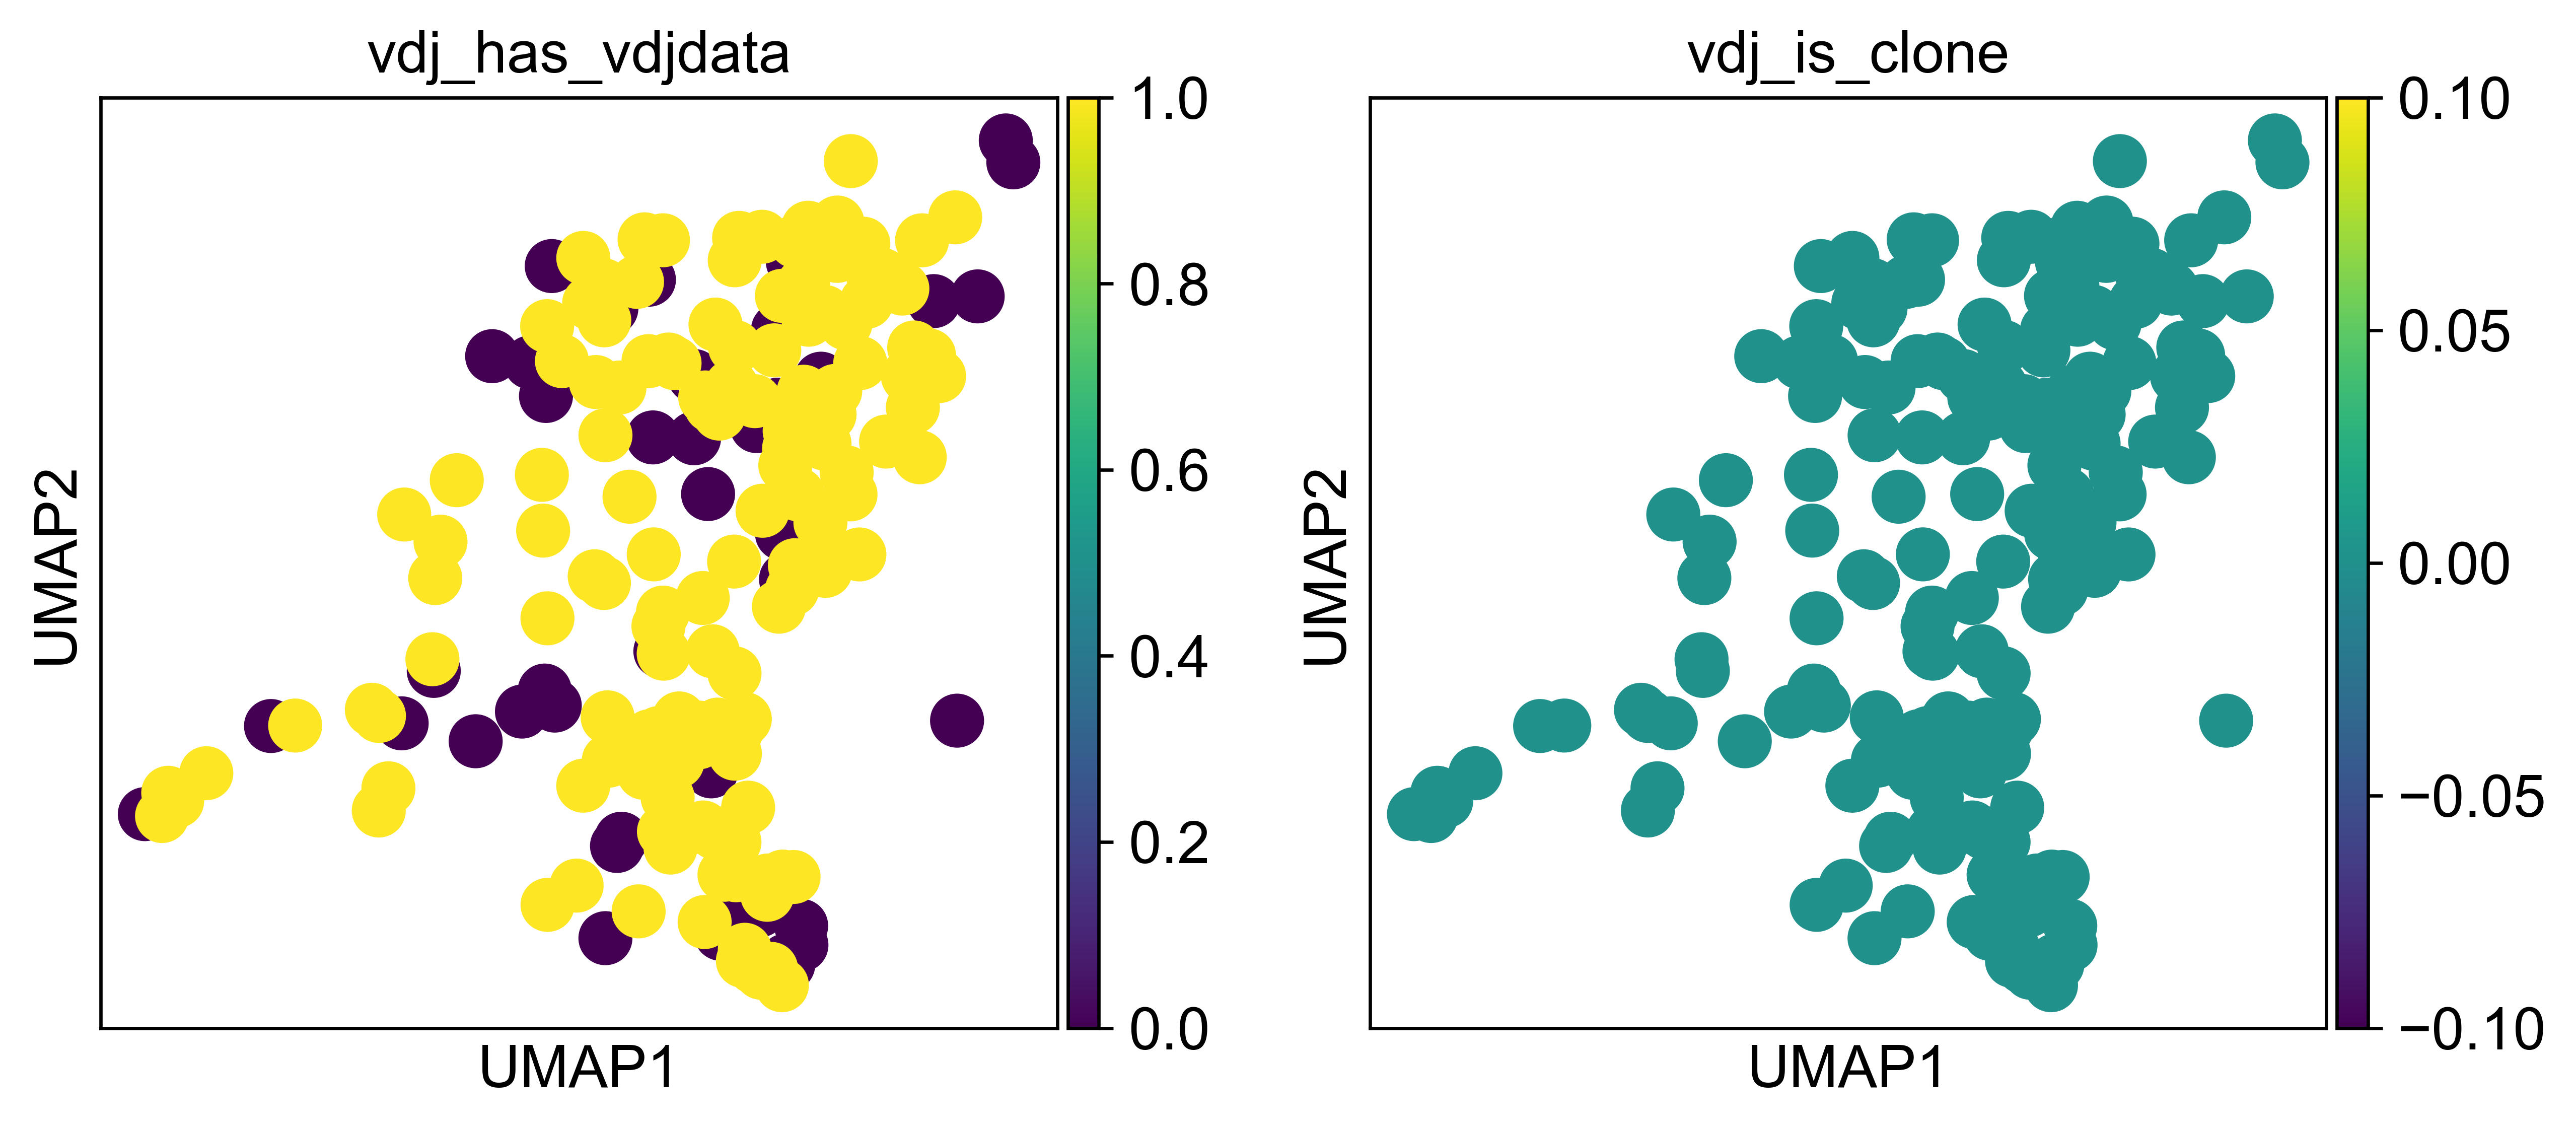

In [21]:
# When running on BCR data, we see the clones are restricted to the B lymphoid cells
sc.pl.umap(adata, color=['vdj_has_vdjdata', 'vdj_is_clone'])

In [22]:
allcell = len(adata.obs['vdj_has_vdjdata'])
vdjcell = sum(adata.obs['vdj_has_vdjdata'])
print('We have %d cells with VDJ data, out of %d cells.' % (vdjcell, allcell))

We have 138 cells with VDJ data, out of 181 cells.


In [23]:
adata.obs['vdj_is_clone'].dtype

dtype('bool')

In [24]:
df = pd.DataFrame({'count' : adata.obs.groupby(["vdj_is_clone", "cell.labels", "orig.ident"]).size()}).reset_index()

In [25]:
clone_df = df[df["vdj_is_clone"]==True]

In [26]:
clone_df

Empty DataFrame
Columns: [vdj_is_clone, cell.labels, orig.ident, count]
Index: []

In [27]:
df = pd.DataFrame({'count' : adata.obs.groupby(["vdj_is_clone", "cell.labels", "orig.ident", "vdj_clonotype"]).size()}).reset_index()

In [28]:
clone_df = df[df["vdj_is_clone"]==True]

In [29]:
clone_df

Empty DataFrame
Columns: [vdj_is_clone, cell.labels, orig.ident, vdj_clonotype, count]
Index: []

In [30]:
is_clone = sum(adata.obs['vdj_is_clone'])
print('We have %d cells with clones, out of %d cells.' % (is_clone, allcell))

We have 0 cells with clones, out of 181 cells.


In [31]:
# productivity = if all productive, all chains (poss 1 - 4) productive. protein coming from the rna.
adata = pyvdj.add_obs(adata, obs=['all_productive', 'any_productive'])

In [32]:
adata.uns['vdj_any_productive_colors'] = ['#1f77b4', '#ff0000']

In [33]:
new = adata[~adata.obs['vdj_has_vdjdata'].isin(['0'])].copy()

... storing 'vdj_all_productive' as categorical
... storing 'vdj_any_productive' as categorical


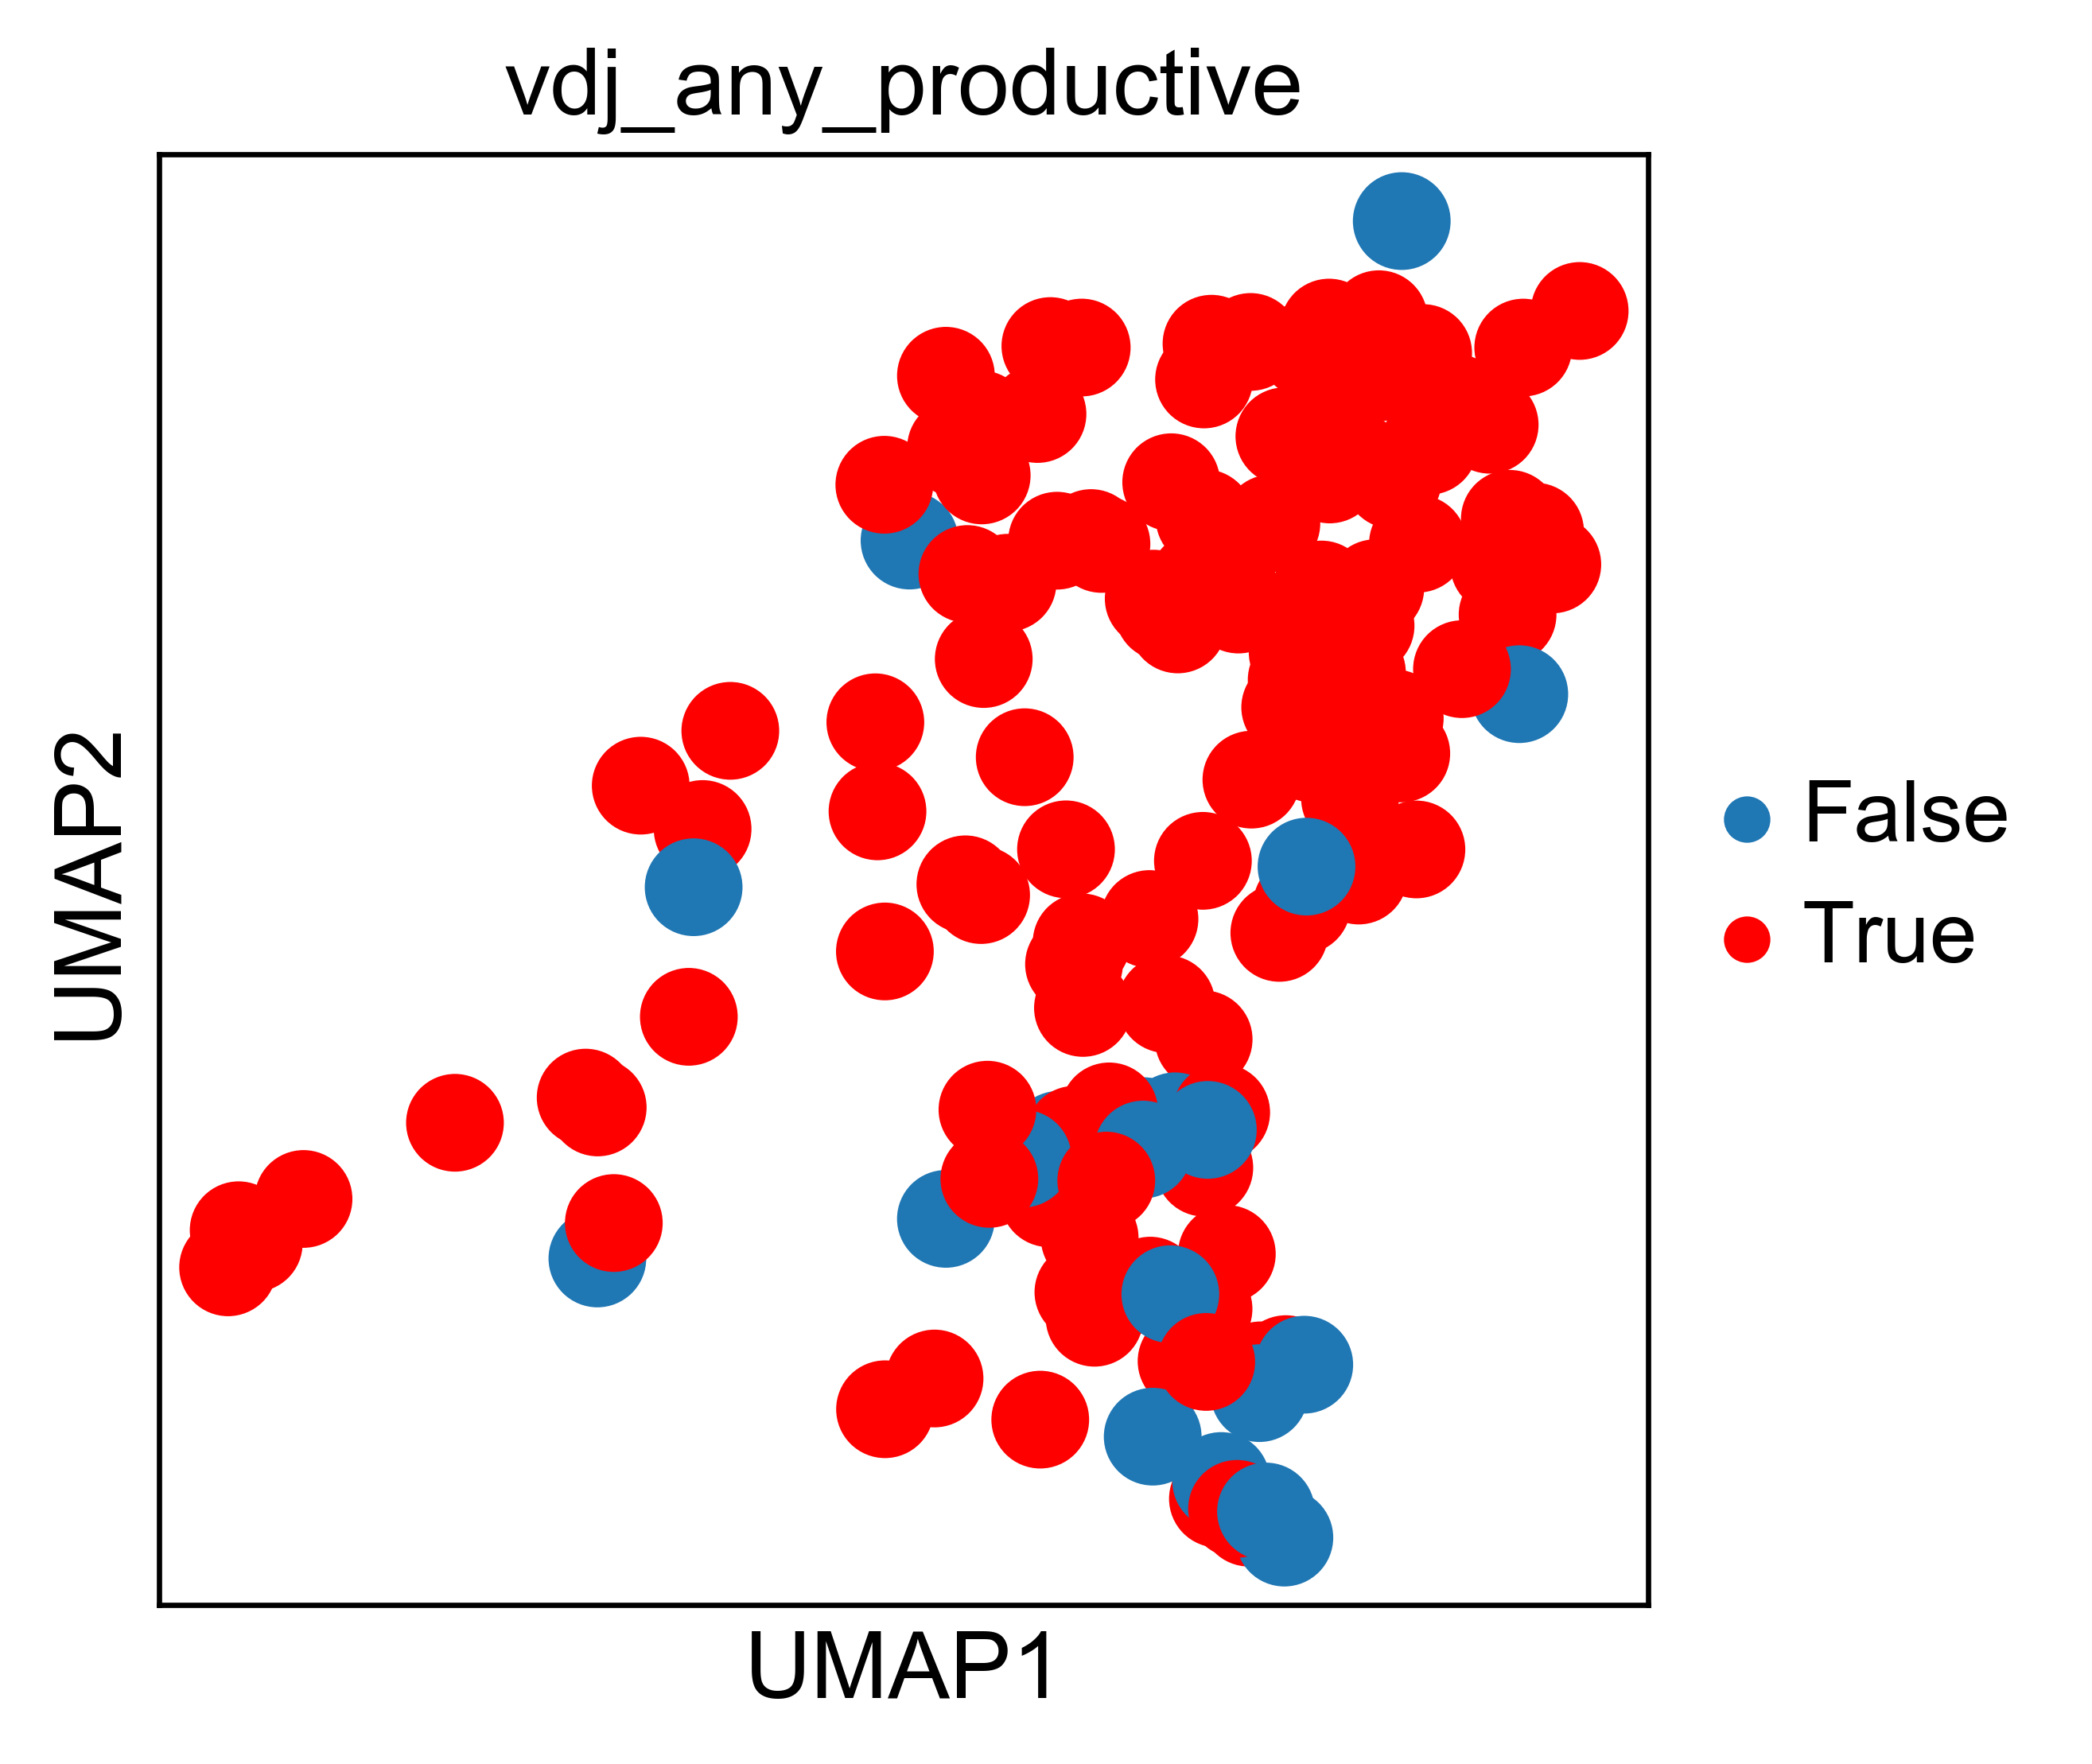

In [34]:
sc.pl.umap(new, color=['vdj_any_productive'], save="tcell_productive_20200718.pdf")

In [35]:
adata.obs.groupby(['vdj_any_productive']).apply(len)

vdj_any_productive
False     21
True     117
dtype: int64

In [36]:
cell_numbers = adata.obs.groupby(["cell.labels", "vdj_any_productive"]).apply(len)
cell_numbers

cell.labels  vdj_any_productive
CD4 T cell   False                  5
             True                  50
CD8 T cell   False                 13
             True                  47
Treg         False                  3
             True                  20
dtype: int64

In [37]:
cell_numbers = adata.obs.groupby(["cell.labels", "orig.ident", "vdj_any_productive"]).apply(len)
pd.DataFrame(cell_numbers).to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/resources_for_pipelines/tcell_vdj_productivity_20200718.csv")
cell_numbers

cell.labels  orig.ident  vdj_any_productive
CD4 T cell   F50         True                  19
             F51         False                  5
                         True                  31
CD8 T cell   F50         False                  2
                         True                  22
             F51         False                 11
                         True                  25
Treg         F50         True                   4
             F51         False                  3
                         True                  16
dtype: int64

# CHAINS

In [38]:
# The following command adds one boolean metnew column (in new.obs) for each type of chain found in the V(D)J data:
new = pyvdj.add_obs(new, obs=['chains'])

TRB
IGL
TRA
Multi
IGH
TRG
TRD
IGK
None


In [39]:
del new.obs["vdj_chain_IGL"]
del new.obs["vdj_chain_IGH"]
del new.obs["vdj_chain_IGK"]

In [40]:
new.obs["ig_chains"] = new.obs["vdj_chain_TRA"].astype(str) + '_' + new.obs["vdj_chain_TRB"].astype(str) + '_' + new.obs["vdj_chain_TRD"].astype(str) + '_' + new.obs["vdj_chain_TRG"].astype(str)

In [41]:
new.obs["vdj_ig_chains"] = new.obs["ig_chains"] 

... storing 'ig_chains' as categorical
... storing 'vdj_ig_chains' as categorical


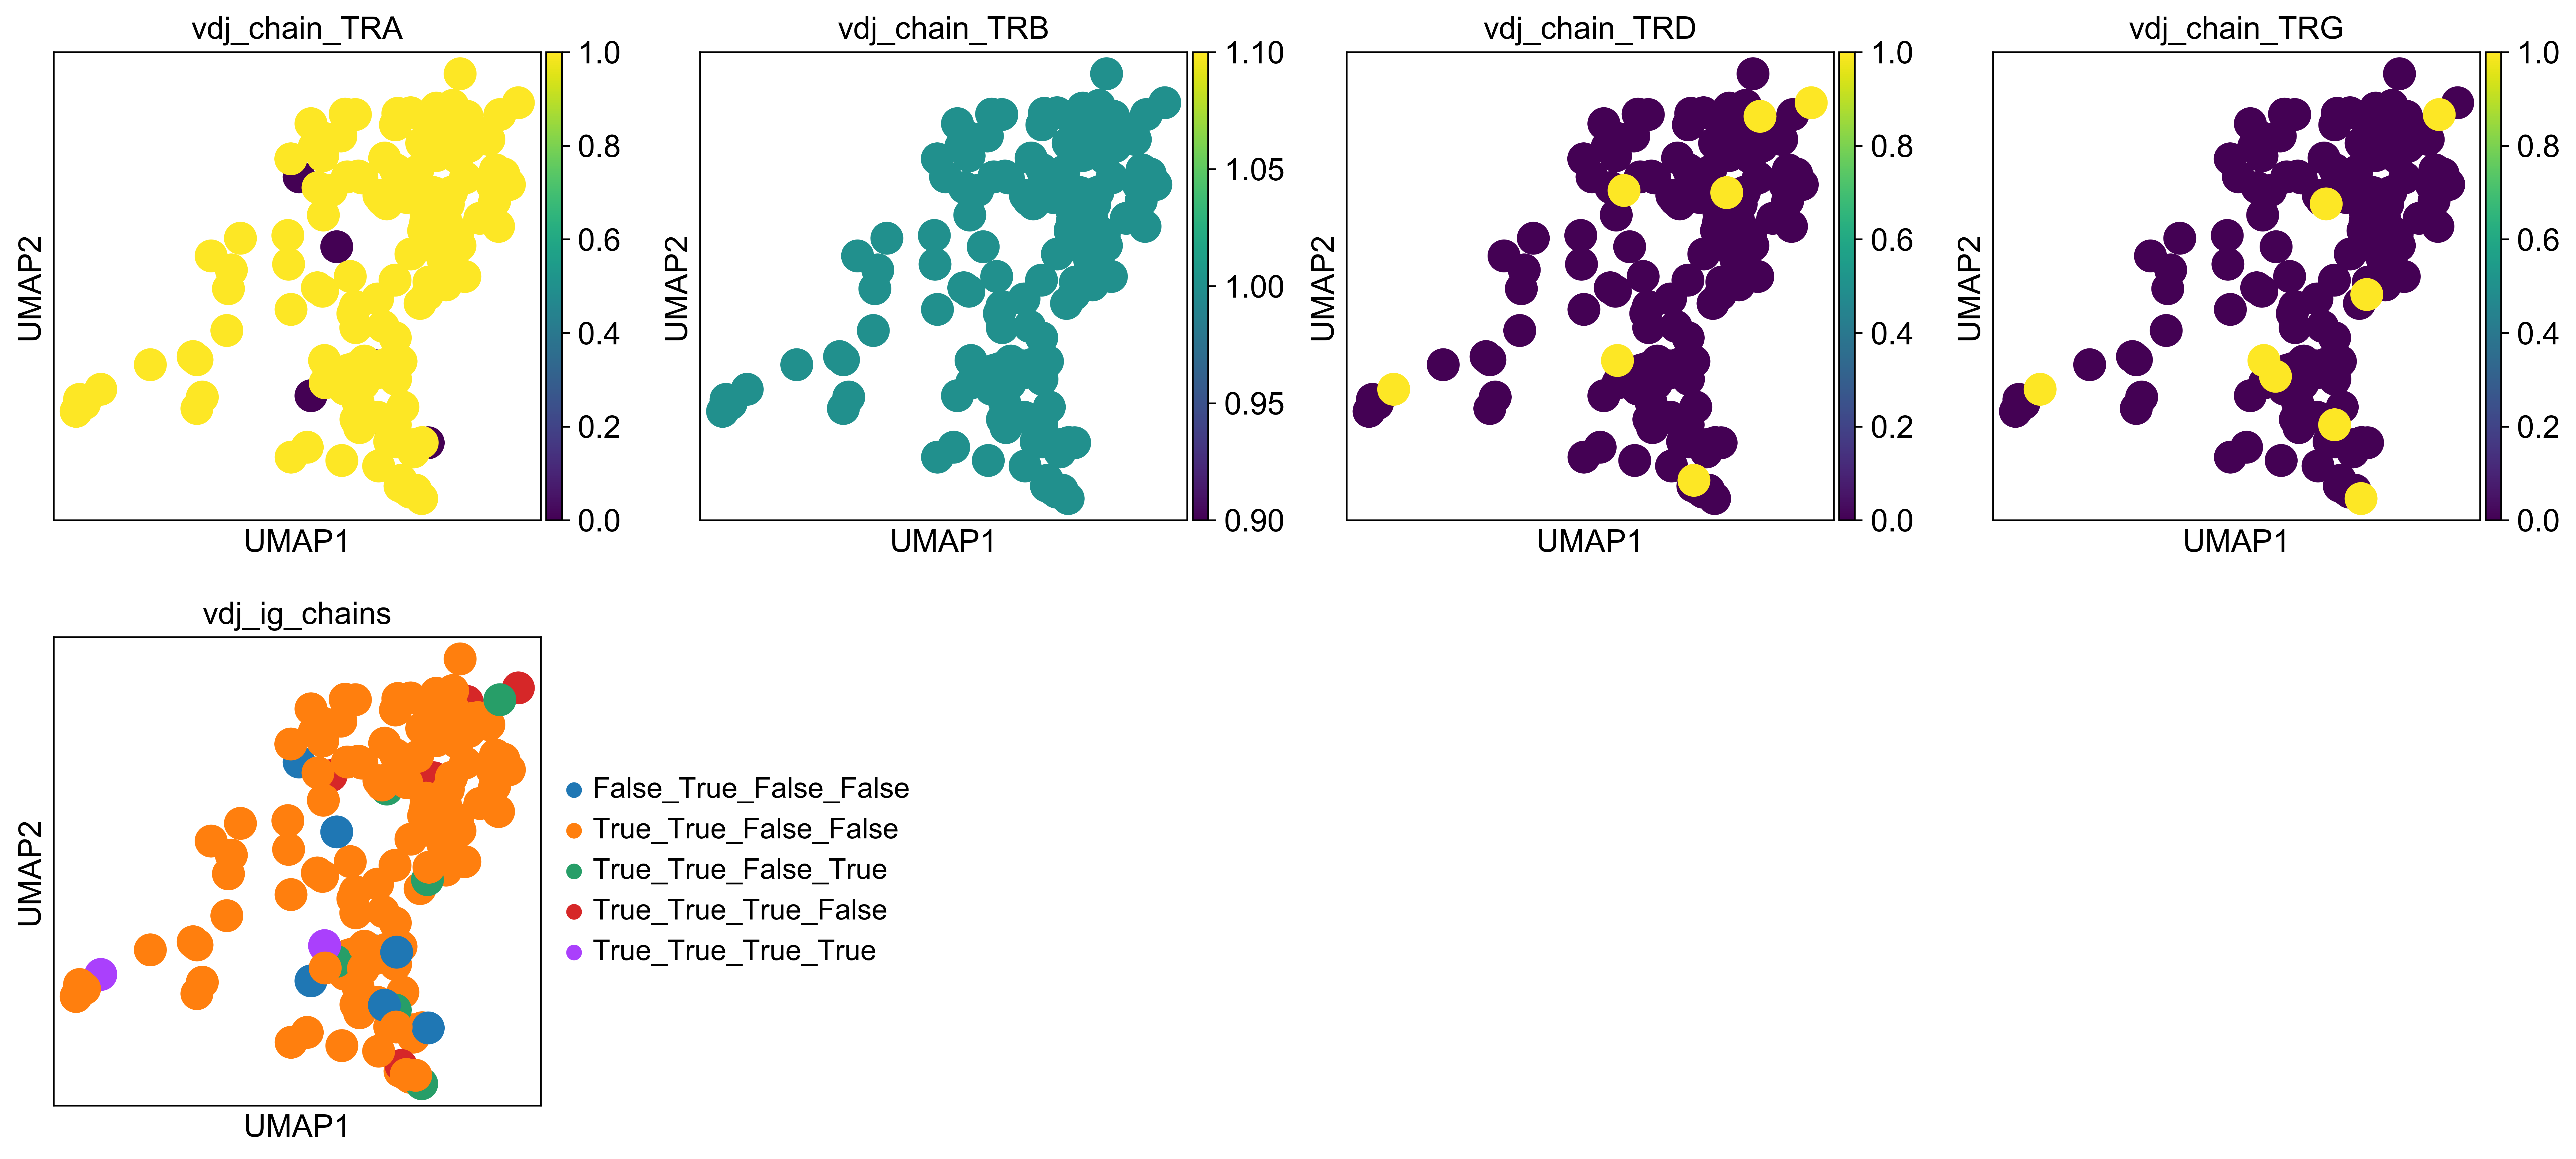

In [42]:
sc.pl.umap(new, color=['vdj_chain_TRA', 'vdj_chain_TRB', 'vdj_chain_TRD', 'vdj_chain_TRG', 'vdj_ig_chains'])

In [43]:
chain_list = ["False_False_False_False", "False_True_False_False", "False_True_False_True", "False_True_True_False", "No_data_No_data_No_data_No_data", "True_False_False_False", "True_True_False_False", "True_True_False_True", "True_True_True_False", "True_True_True_True"]
chain_list_new = ["no_chains", "TRB", "TRB+G", "TRB+D", "no_vdj_data", "TRA", "TRA+B", "TRA+B+G", "TRA+B+D", "TRA+B+D+G"]

In [44]:
new.obs["vdj_ig_chains"] = new.obs["vdj_ig_chains"].replace(chain_list, chain_list_new)

In [45]:
new.obs["vdj_ig_chains"] = new.obs["vdj_ig_chains"].astype("category")

In [46]:
new.uns['vdj_ig_chains_colors'] = ['#000000', '#800080', '#d200d2', '#0000ff', '#ff0000', '#00d200', '#00d6ff', '#9c9c9c', '#ececec']

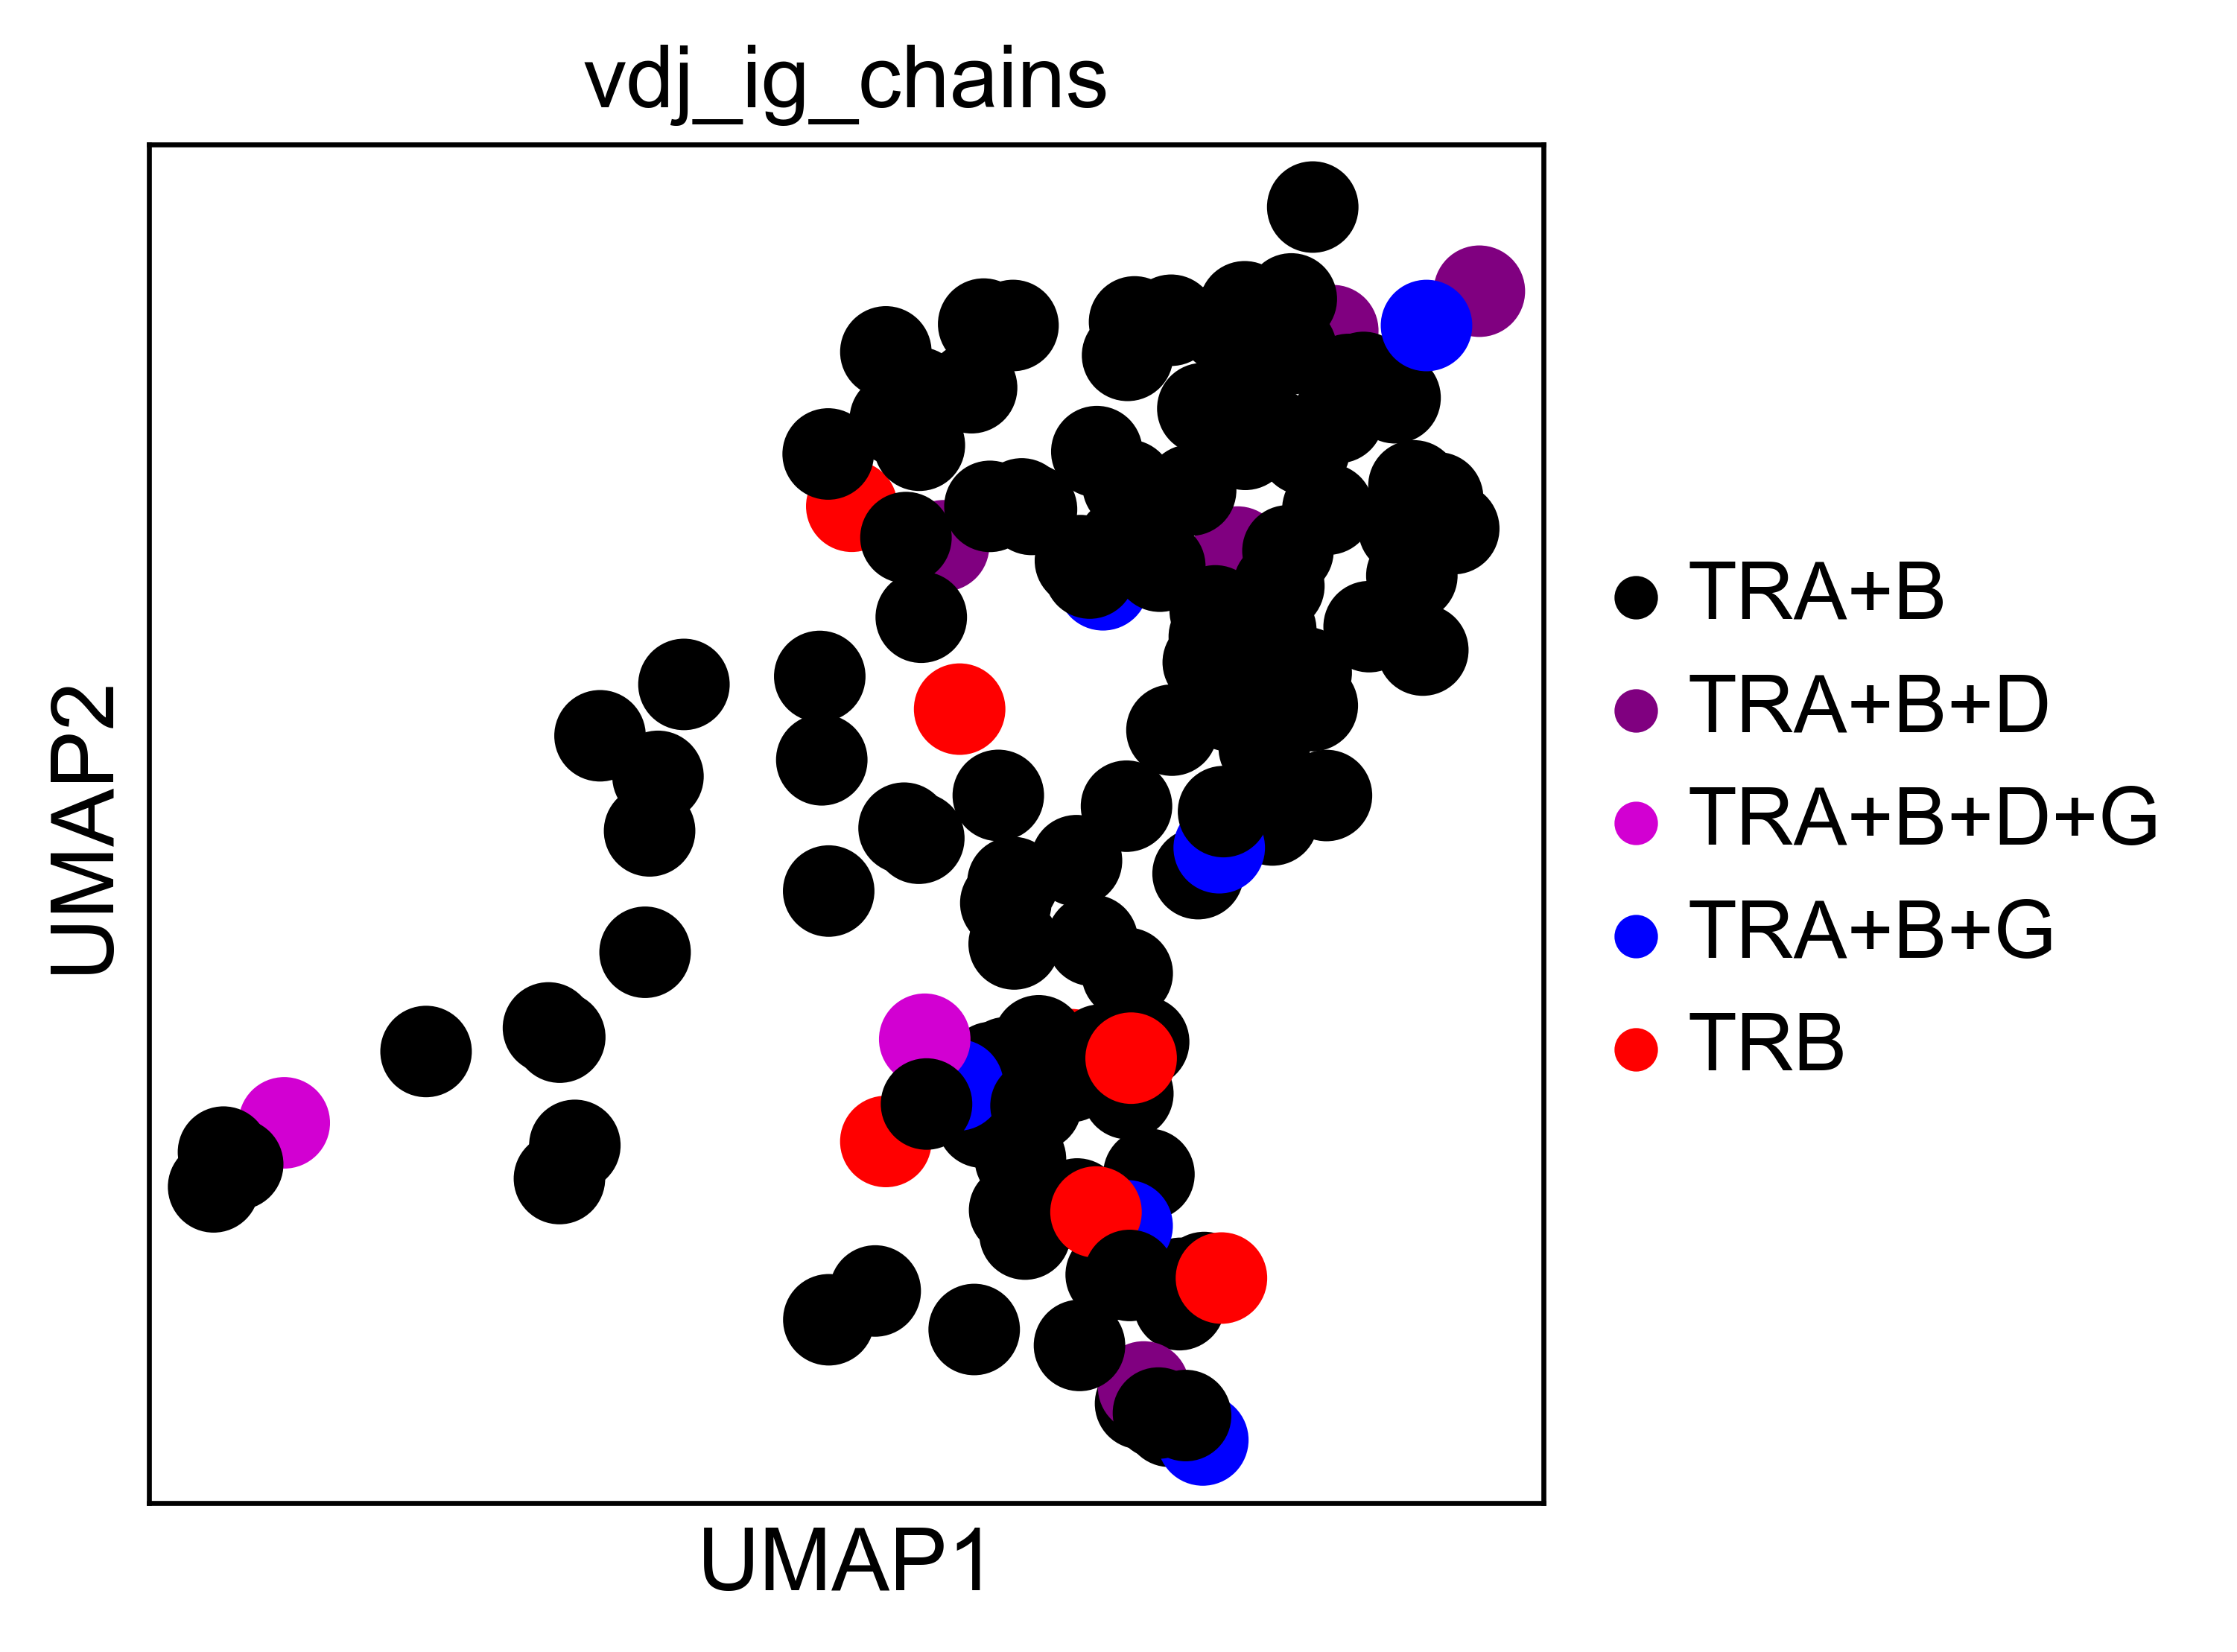

In [47]:
sc.pl.umap(new, color='vdj_ig_chains')

In [48]:
new.obs.groupby(['vdj_ig_chains']).apply(len)

vdj_ig_chains
TRA+B        118
TRA+B+D        5
TRA+B+D+G      2
TRA+B+G        6
TRB            7
dtype: int64

In [49]:
new.obs.groupby(['vdj_chain_TRD']).apply(len)

vdj_chain_TRD
False    131
True       7
dtype: int64

In [50]:
new.obs.groupby(['vdj_chain_TRG']).apply(len)

vdj_chain_TRG
False    130
True       8
dtype: int64

In [51]:
new.obs.groupby(['vdj_chain_TRA']).apply(len)

vdj_chain_TRA
False      7
True     131
dtype: int64

In [52]:
new.obs.groupby(['vdj_chain_TRB']).apply(len)

vdj_chain_TRB
True    138
dtype: int64

# INDIVIDUAL CHAINS

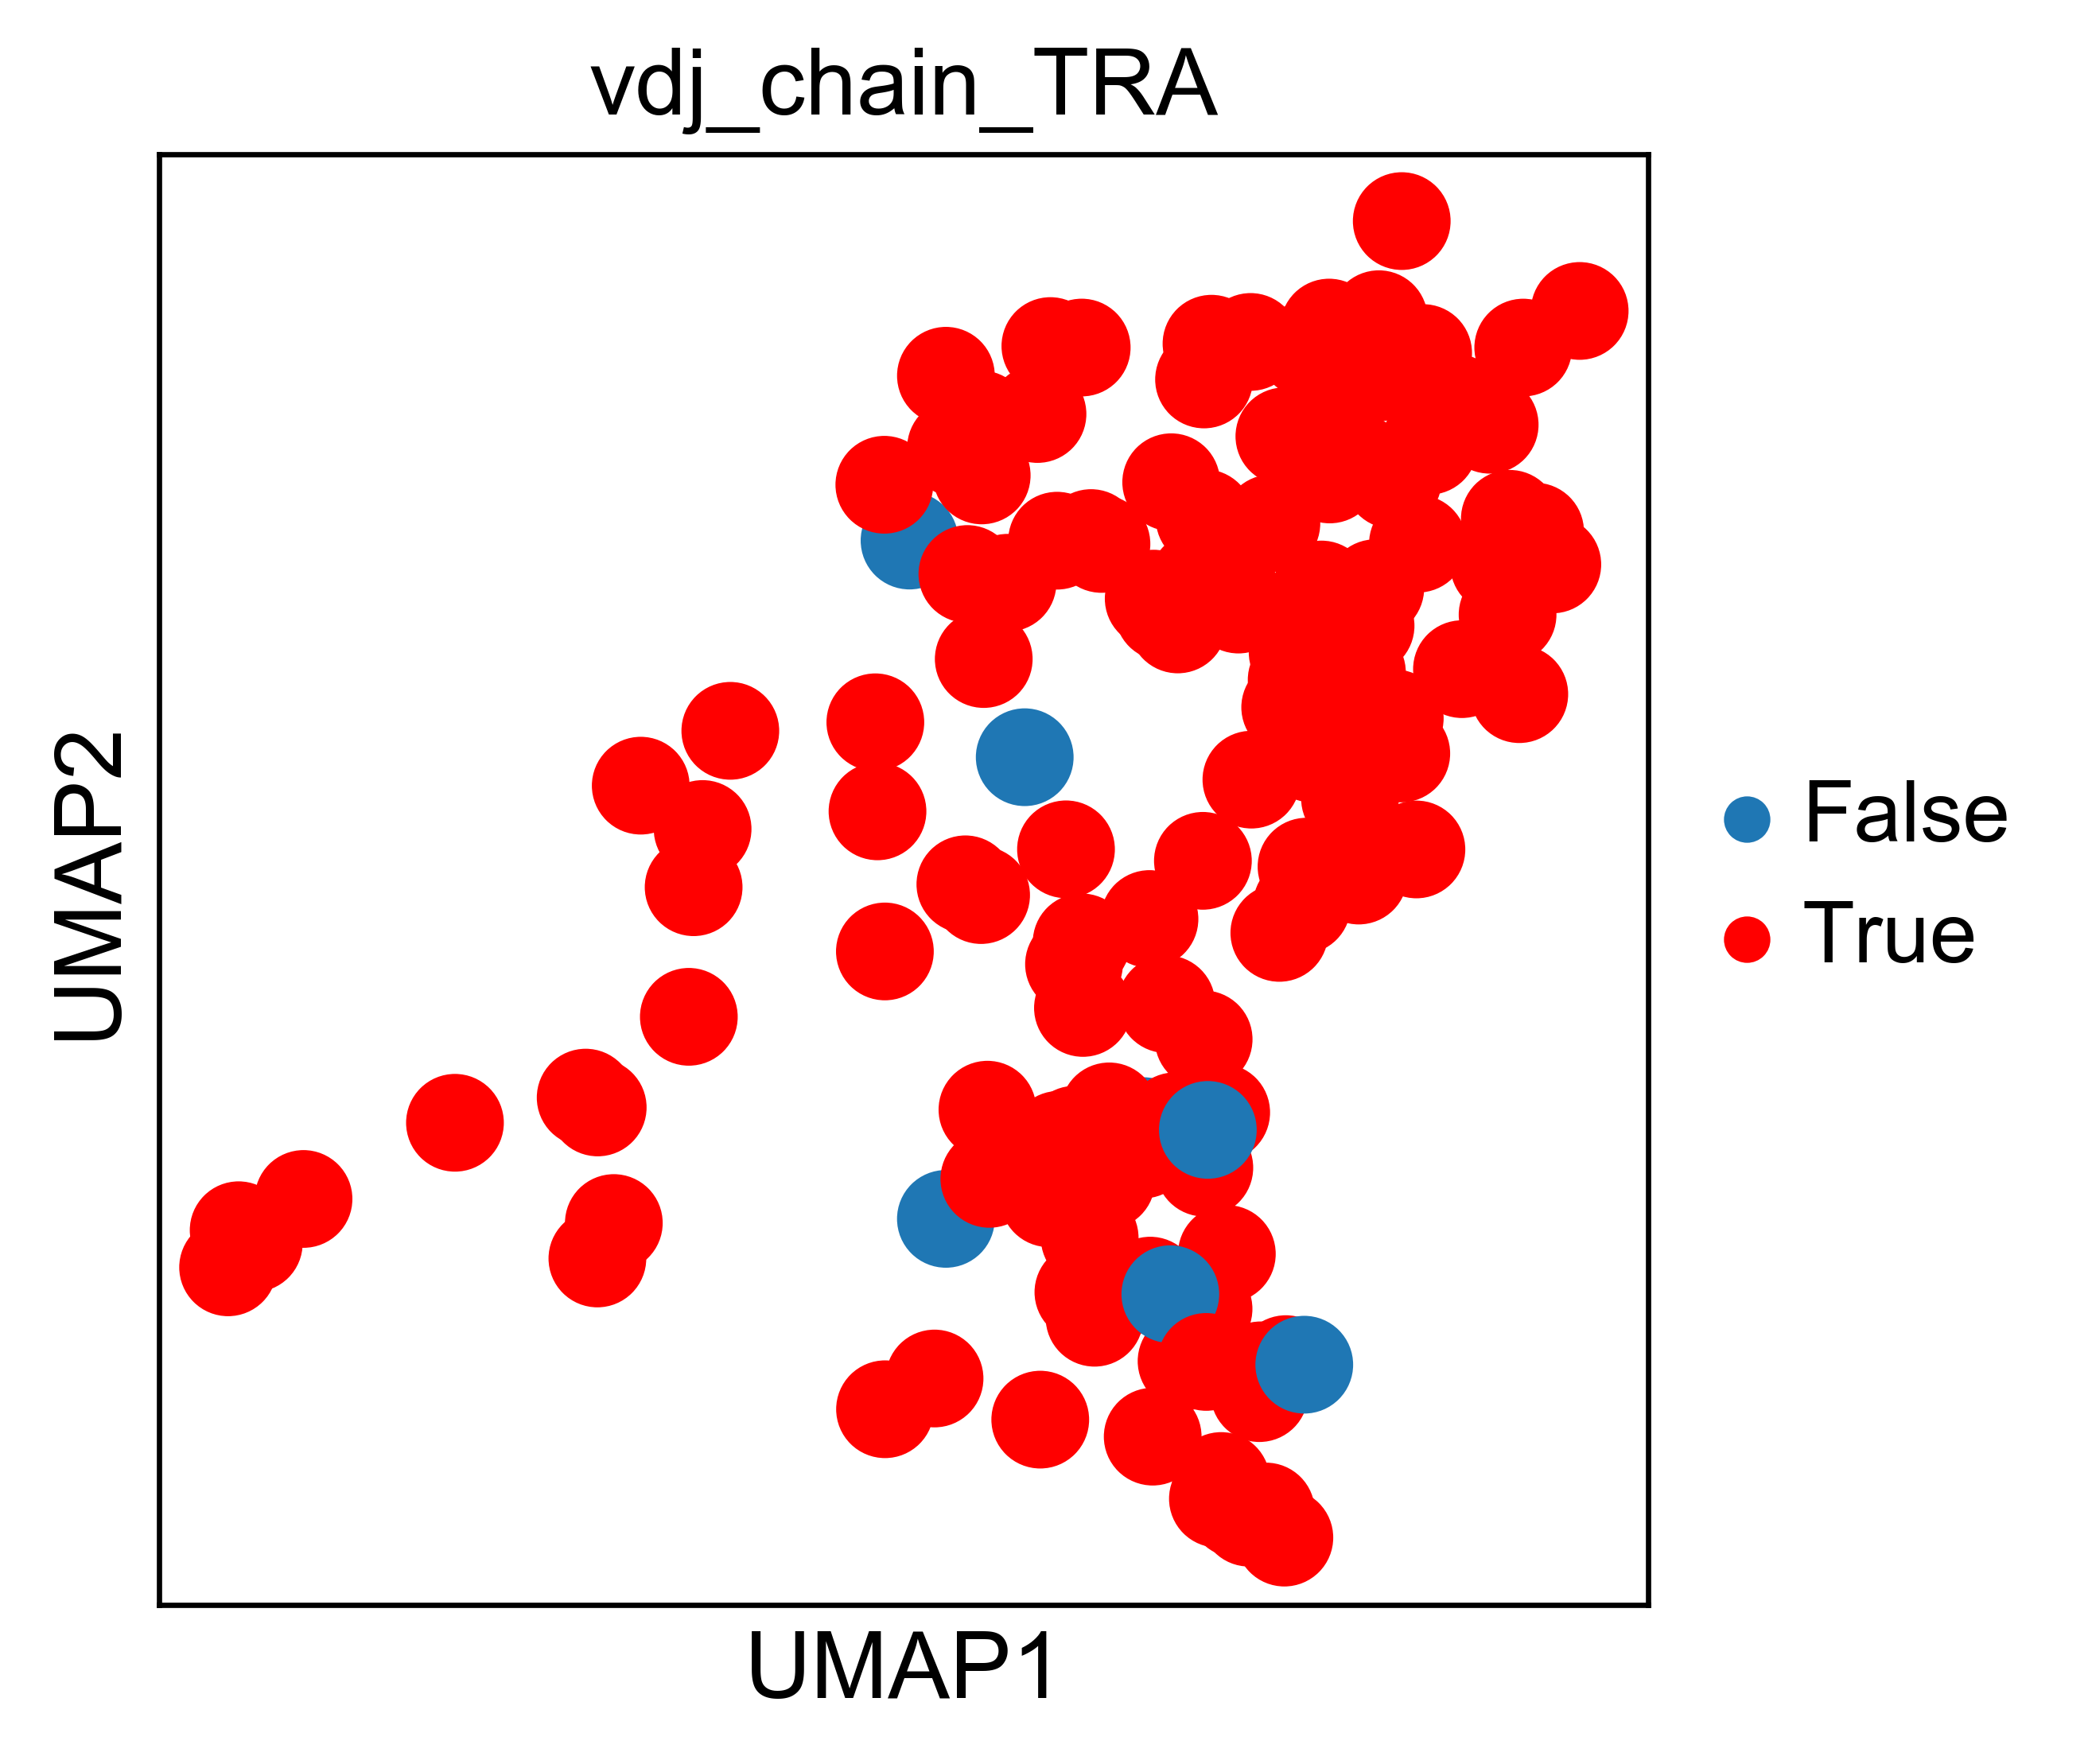

In [53]:
new.obs["vdj_chain_TRA"] = new.obs["vdj_chain_TRA"].astype("category")

chain_list = ["False", "No_data", "True"]
chain_list_new = ["no_TRA", "no_data", "TRA_detected"]

new.obs["vdj_chain_TRA"] = new.obs["vdj_chain_TRA"].replace(chain_list, chain_list_new)
new.obs.groupby(['vdj_chain_TRA']).apply(len)

new.uns['vdj_chain_TRA_colors'] = ['#1f77b4', '#ff0000']

sc.pl.umap(new, color='vdj_chain_TRA', save = "tcell_vdj_traa_20200718.pdf")

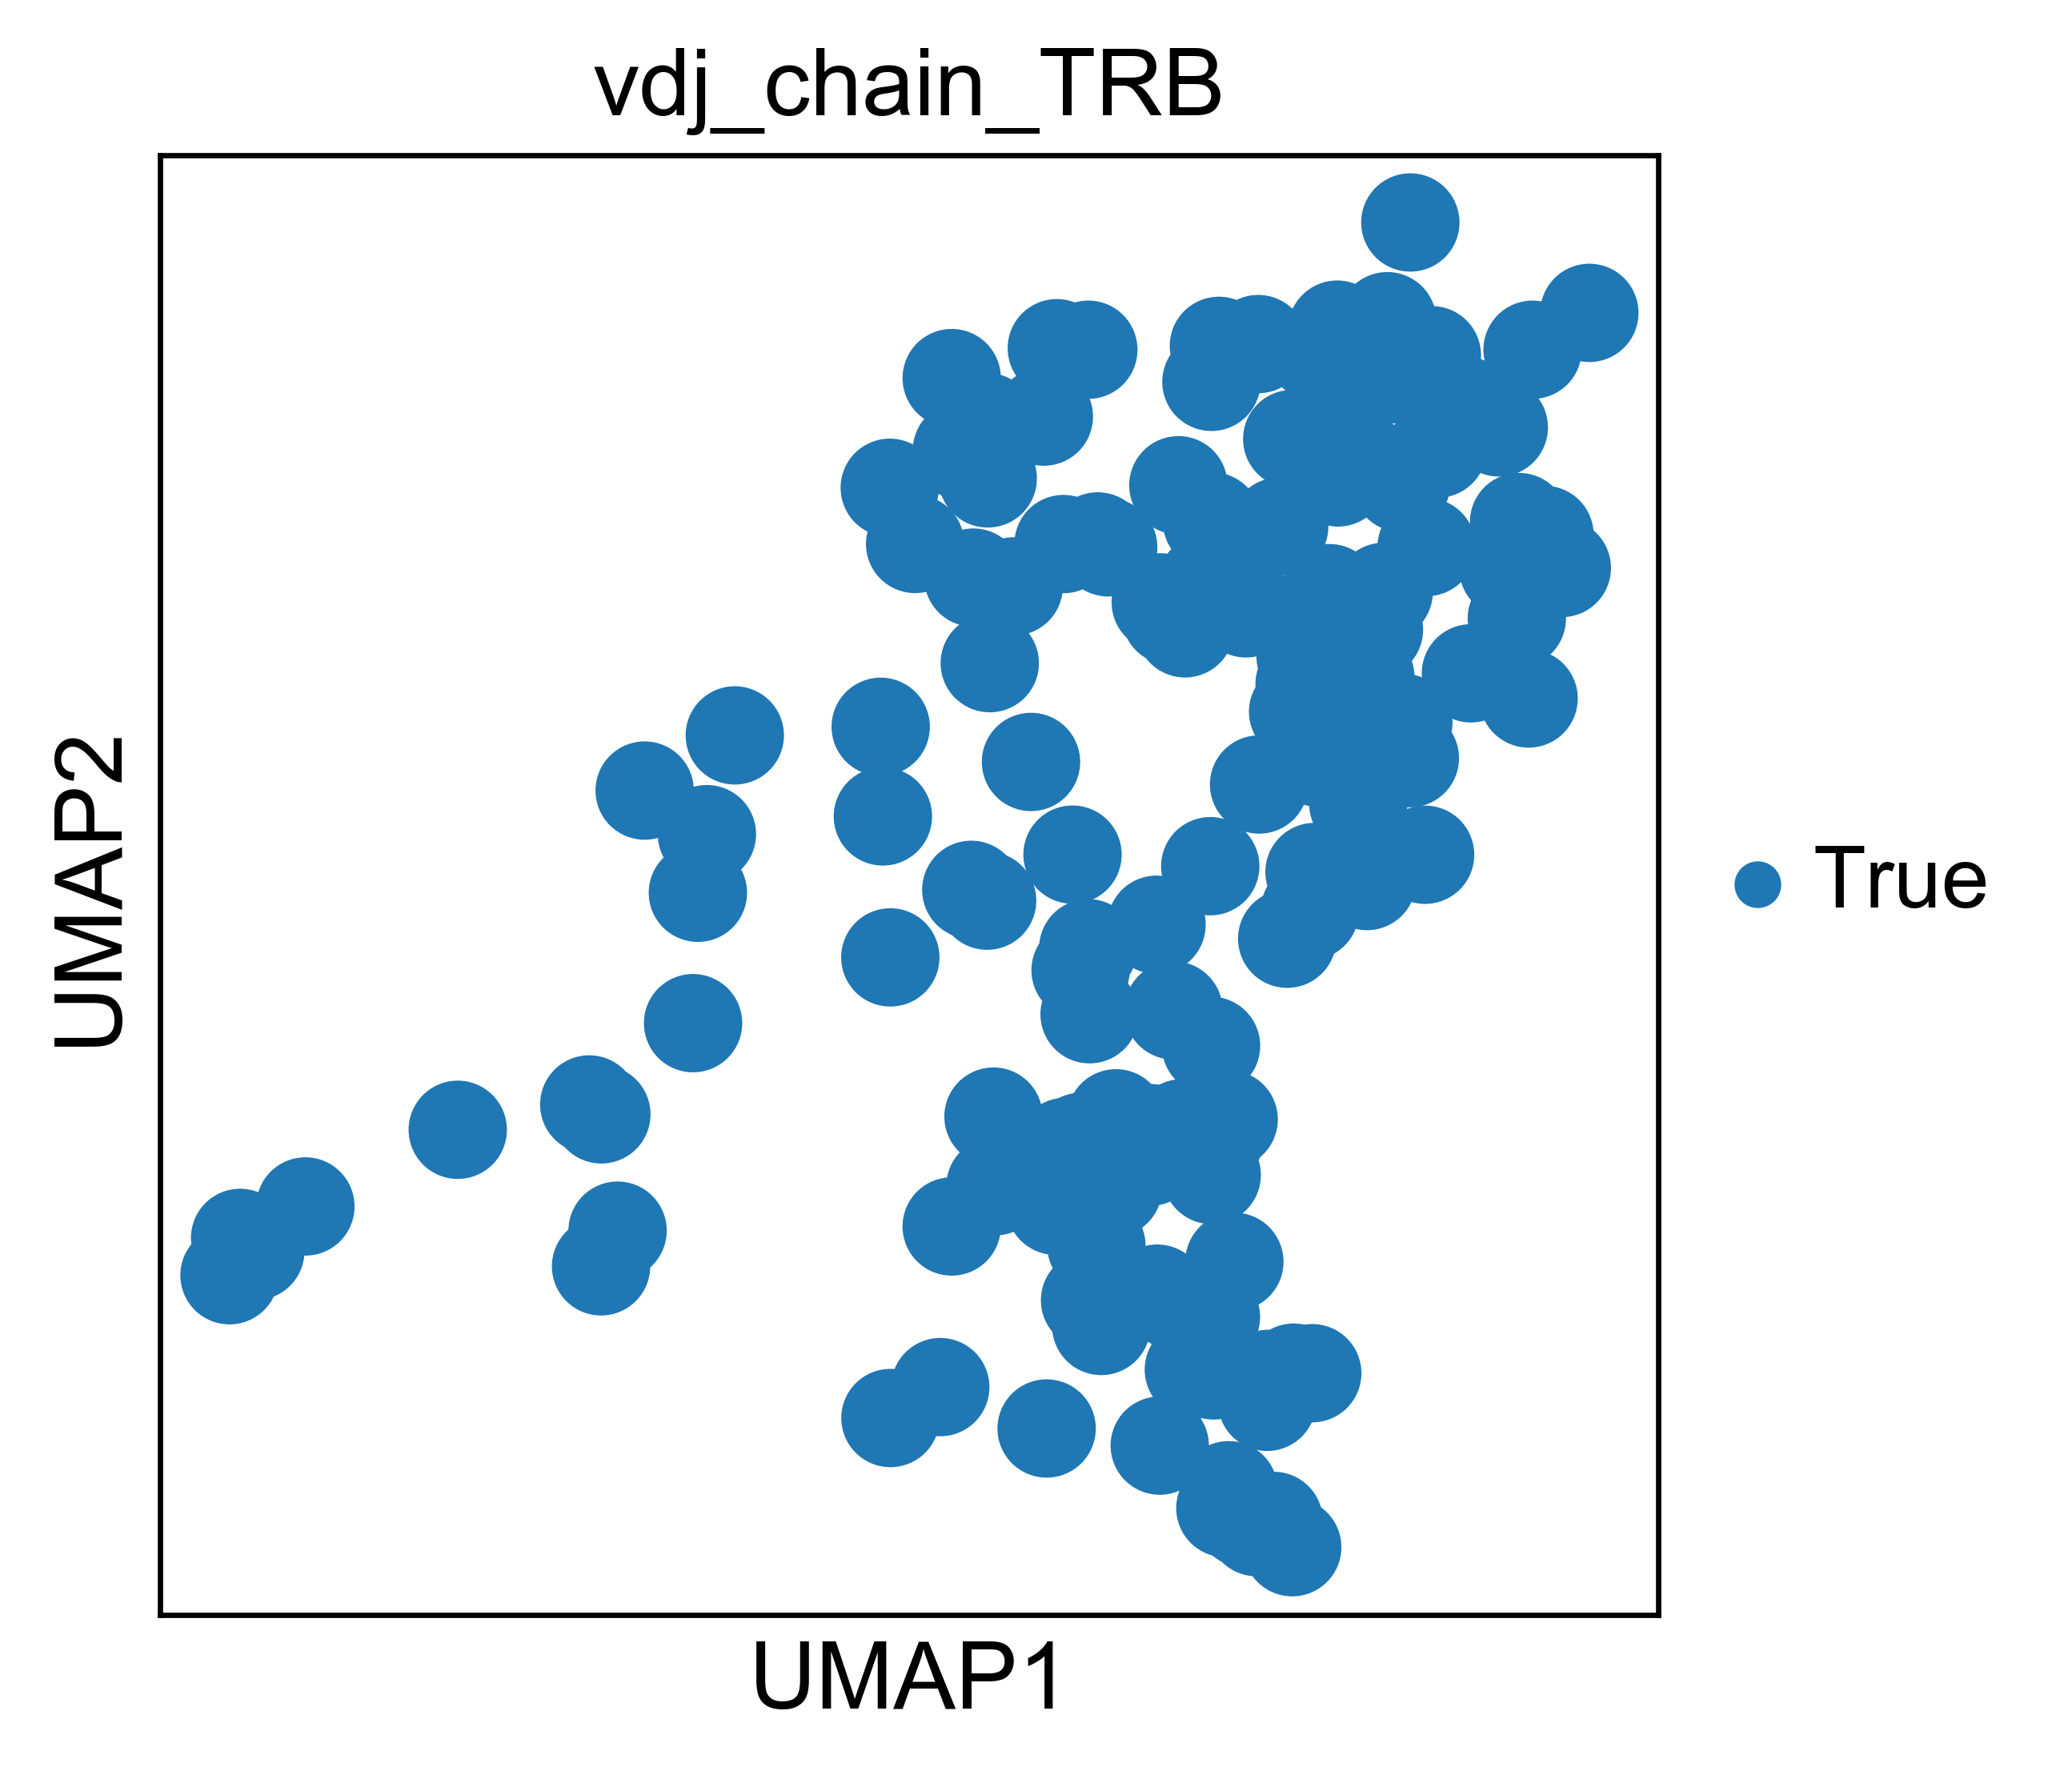

In [54]:
new.obs["vdj_chain_TRB"] = new.obs["vdj_chain_TRB"].astype("category")

chain_list = ["False", "No_data", "True"]
chain_list_new = ["no_TRB", "no_data", "TRB_detected"]

new.obs["vdj_chain_TRB"] = new.obs["vdj_chain_TRB"].replace(chain_list, chain_list_new)
new.obs.groupby(['vdj_chain_TRB']).apply(len)

new.uns['vdj_chain_TRB_colors'] = ['#1f77b4', '#ff0000']

sc.pl.umap(new, color='vdj_chain_TRB', save = "tcell_vdj_trb_20200718.pdf")

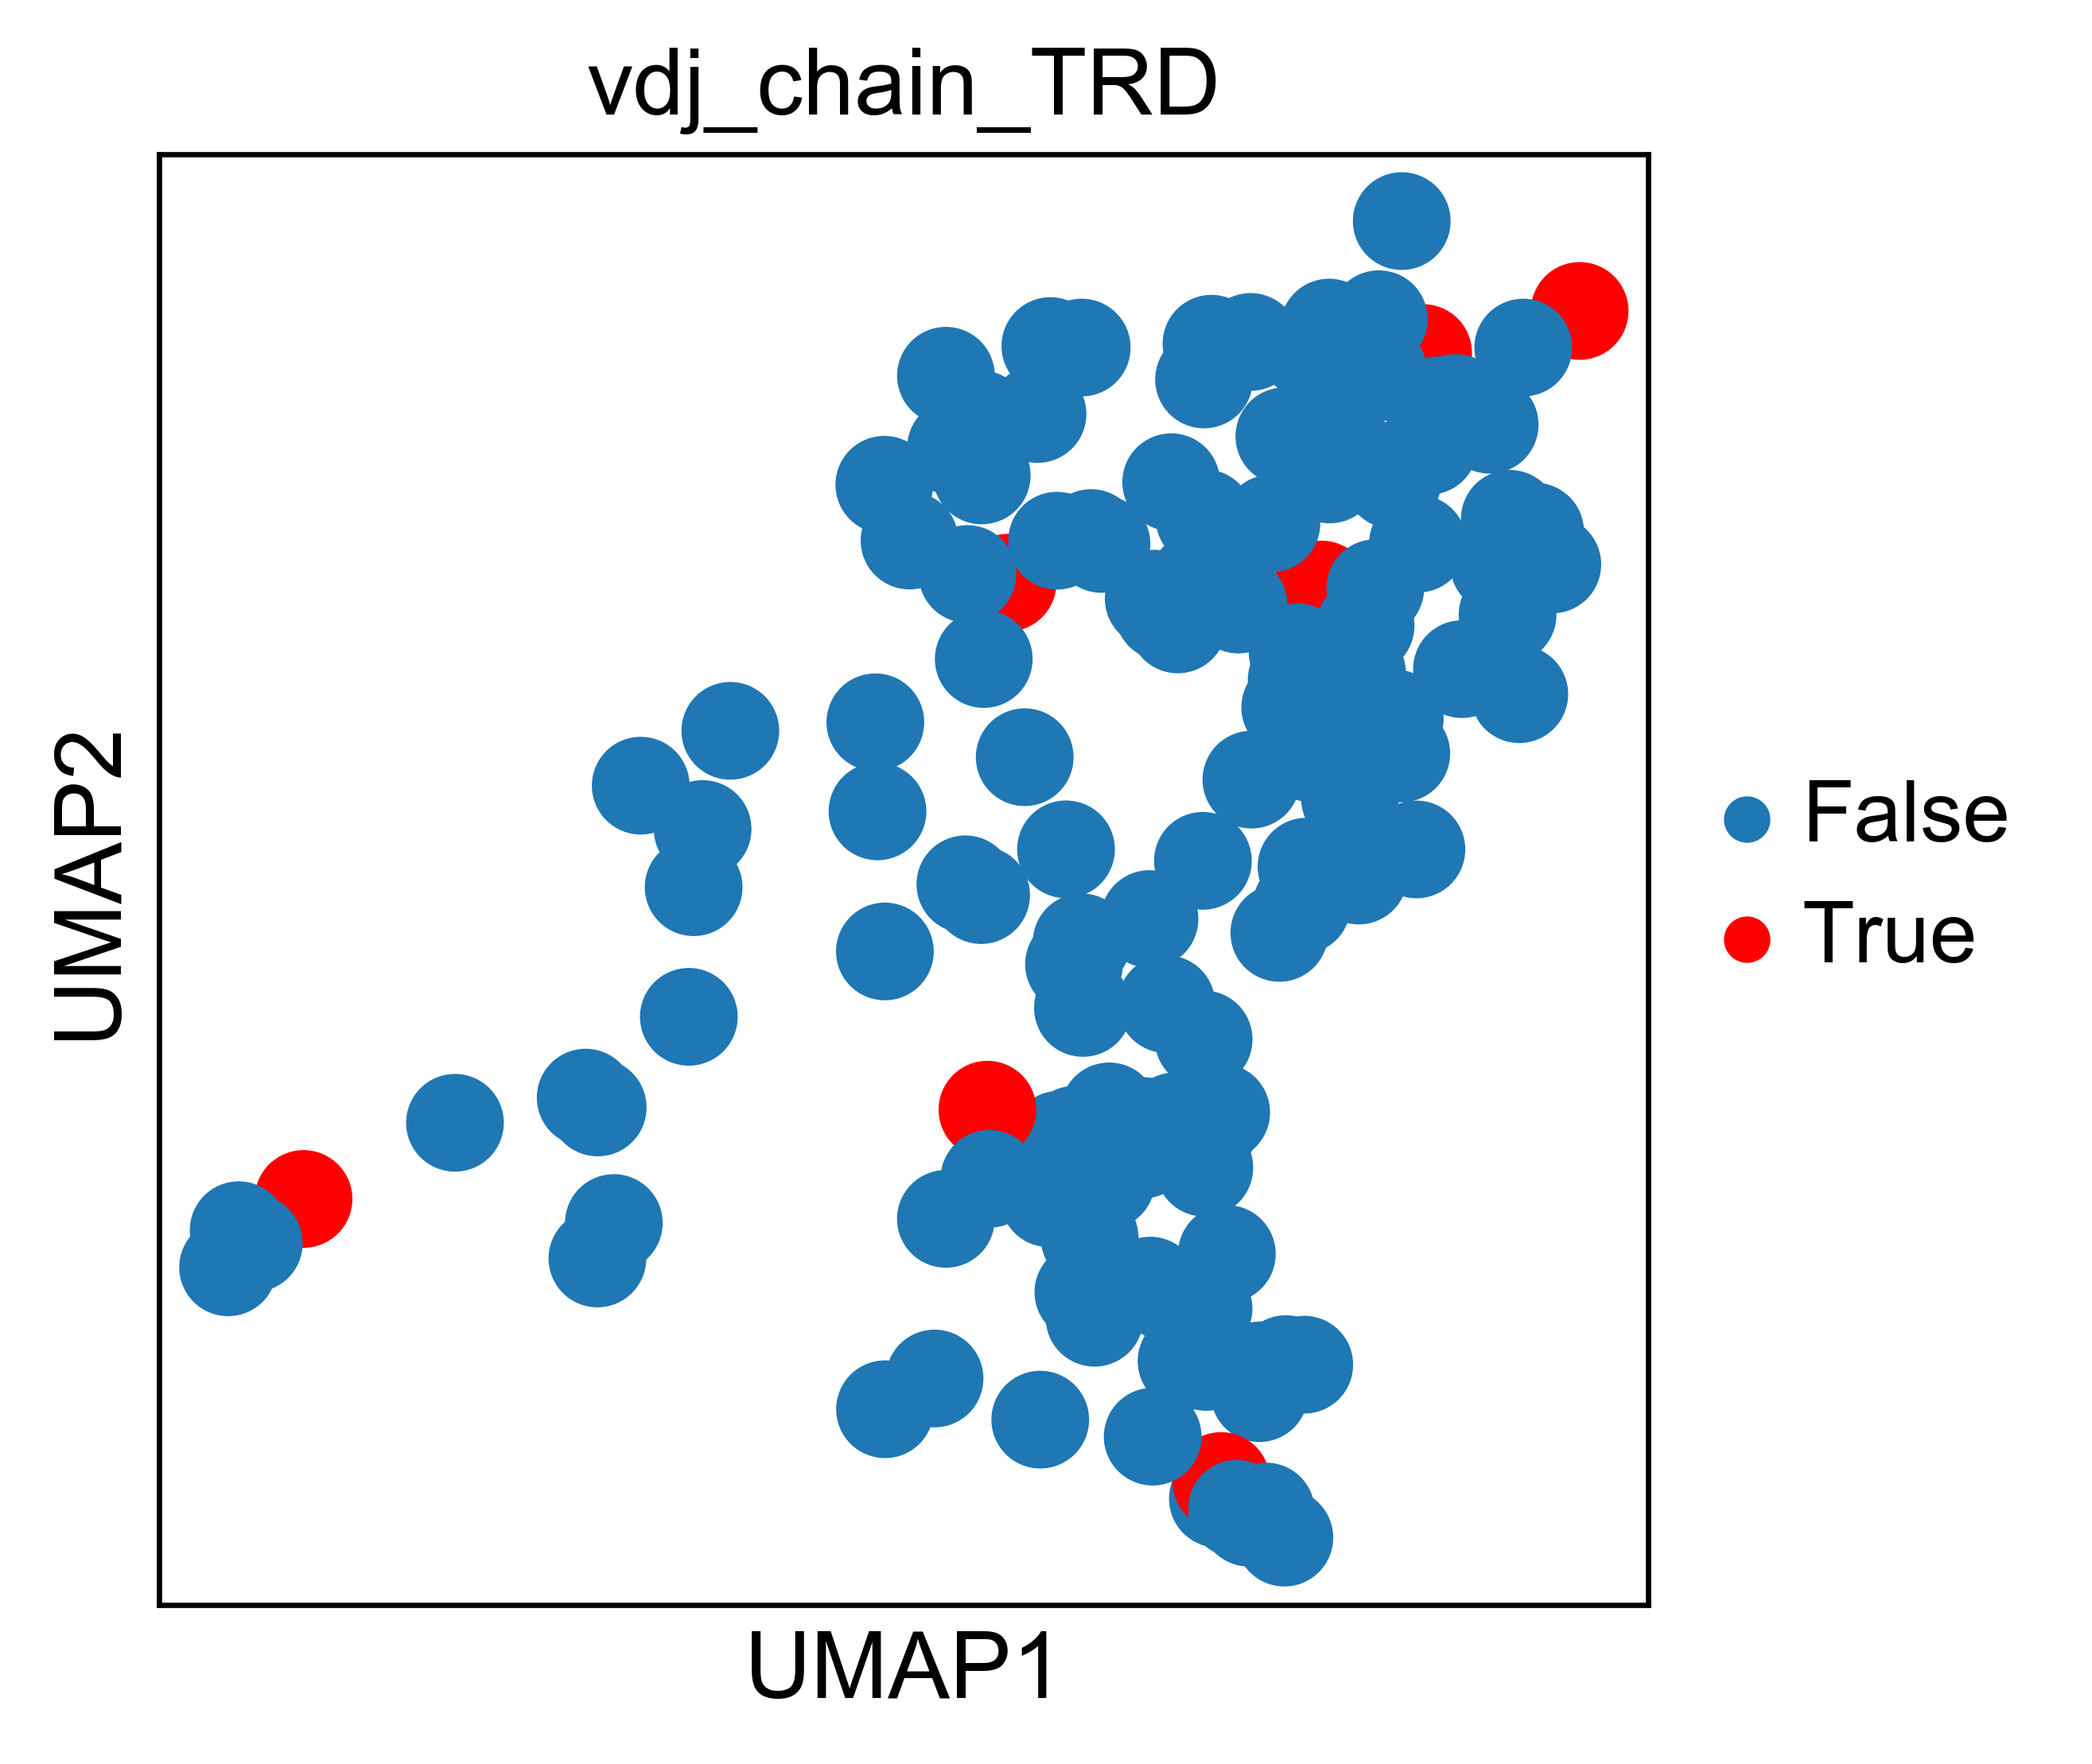

In [55]:
new.obs["vdj_chain_TRD"] = new.obs["vdj_chain_TRD"].astype("category")

chain_list = ["False", "No_data", "True"]
chain_list_new = ["no_TRD", "no_data", "TRD_detected"]

new.obs["vdj_chain_TRD"] = new.obs["vdj_chain_TRD"].replace(chain_list, chain_list_new)
new.obs.groupby(['vdj_chain_TRD']).apply(len)

new.uns['vdj_chain_TRD_colors'] = ['#1f77b4', '#ff0000']

sc.pl.umap(new, color='vdj_chain_TRD', save = "tcell_vdj_trd_20200718.pdf")

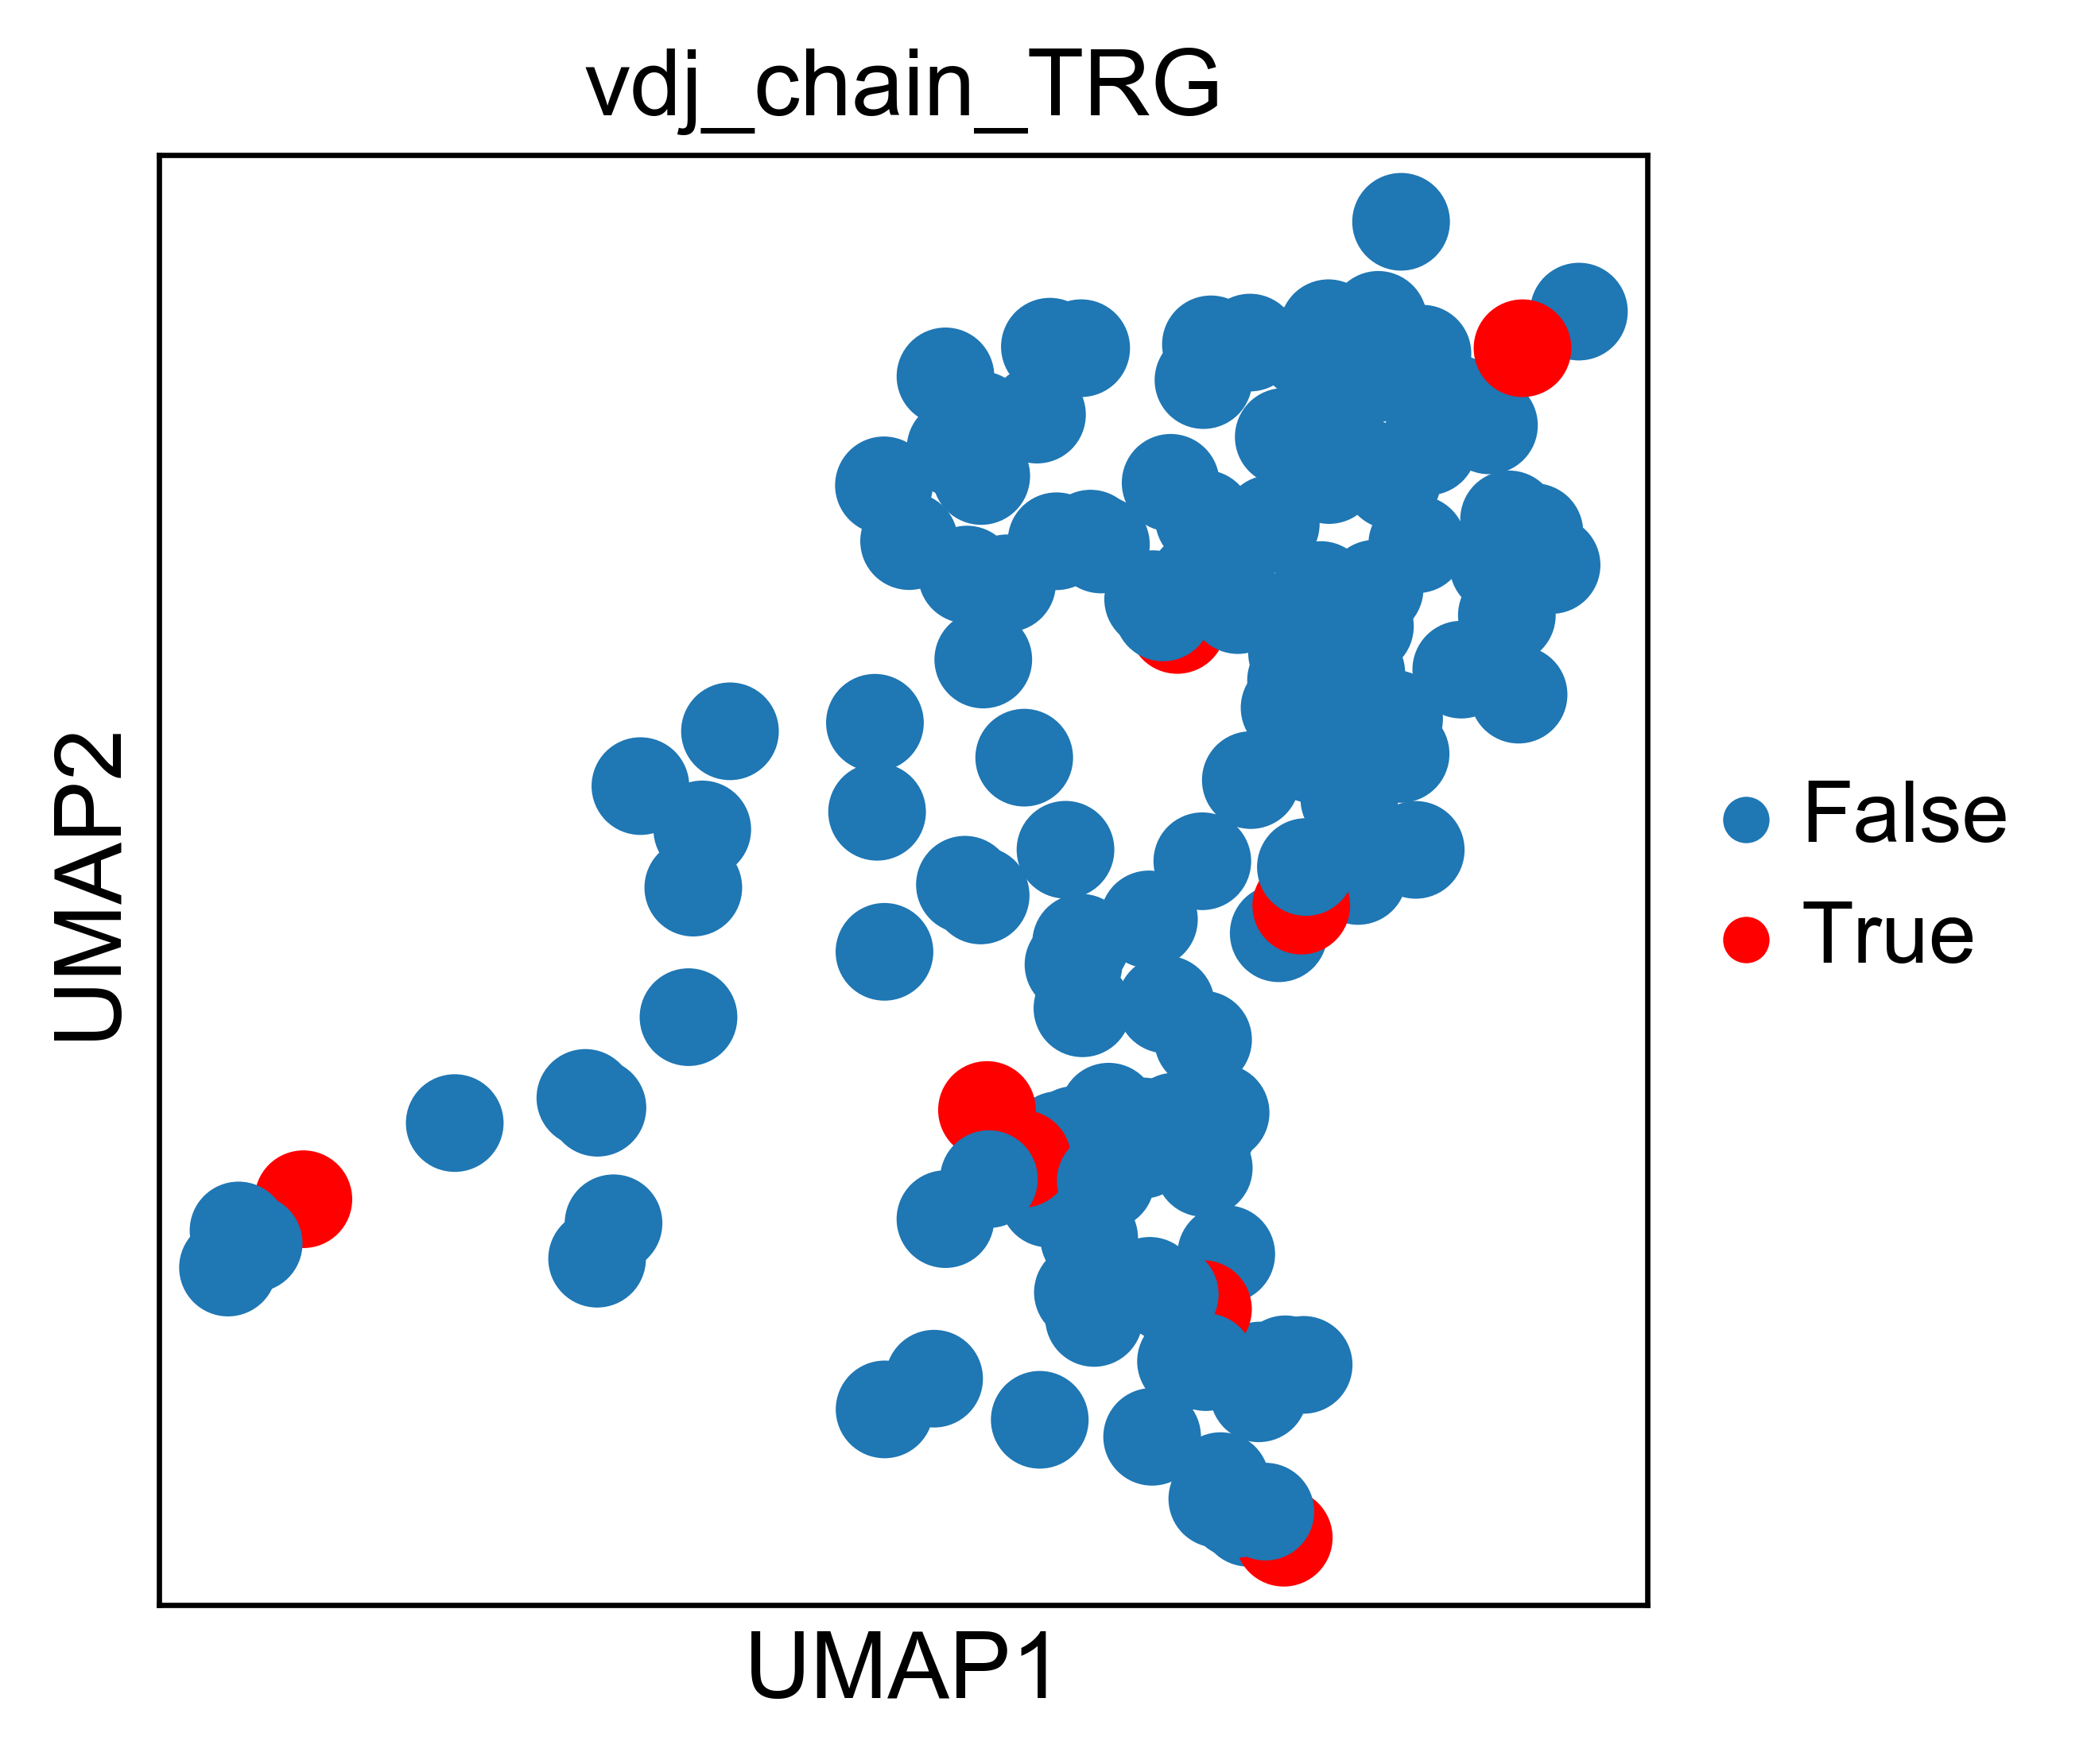

In [56]:
new.obs["vdj_chain_TRG"] = new.obs["vdj_chain_TRG"].astype("category")

chain_list = ["False", "No_data", "True"]
chain_list_new = ["no_TRG", "no_data", "TRG_detected"]

new.obs["vdj_chain_TRG"] = new.obs["vdj_chain_TRG"].replace(chain_list, chain_list_new)
new.obs.groupby(['vdj_chain_TRG']).apply(len)

new.uns['vdj_chain_TRG_colors'] = ['#1f77b4', '#ff0000']

sc.pl.umap(new, color='vdj_chain_TRG', save = "tcell_vdj_trg_20200718.pdf")

In [57]:
adata = new

In [58]:
cell_numbers = adata.obs.groupby(["cell.labels", "orig.ident", "vdj_chain_TRA"]).apply(len)
pd.DataFrame(cell_numbers).to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/resources_for_pipelines/tcell_vdj_chains_TRA_20200718.csv")

cell_numbers = adata.obs.groupby(["cell.labels", "orig.ident", "vdj_chain_TRB"]).apply(len)
pd.DataFrame(cell_numbers).to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/resources_for_pipelines/tcell_vdj_chains_TRB_20200718.csv")

cell_numbers = adata.obs.groupby(["cell.labels", "orig.ident", "vdj_chain_TRD"]).apply(len)
pd.DataFrame(cell_numbers).to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/resources_for_pipelines/tcell_vdj_chains_TRD_20200718.csv")

cell_numbers = adata.obs.groupby(["cell.labels", "orig.ident", "vdj_chain_TRG"]).apply(len)
pd.DataFrame(cell_numbers).to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/resources_for_pipelines/tcell_vdj_chains_TRG_20200718.csv")

In [59]:
cell_numbers = adata.obs.groupby(["vdj_any_productive", "cell.labels", "orig.ident", "vdj_chain_TRA"]).apply(len)
pd.DataFrame(cell_numbers).to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/resources_for_pipelines/tcell_vdj_chains_TRA_productive_20200718.csv")

cell_numbers = adata.obs.groupby(["vdj_any_productive", "cell.labels", "orig.ident", "vdj_chain_TRB"]).apply(len)
pd.DataFrame(cell_numbers).to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/resources_for_pipelines/tcell_vdj_chains_TRB_productive_20200718.csv")

cell_numbers = adata.obs.groupby(["vdj_any_productive", "cell.labels", "orig.ident", "vdj_chain_TRD"]).apply(len)
pd.DataFrame(cell_numbers).to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/resources_for_pipelines/tcell_vdj_chains_TRD_productive_20200718.csv")

cell_numbers = adata.obs.groupby(["vdj_any_productive", "cell.labels", "orig.ident", "vdj_chain_TRG"]).apply(len)
pd.DataFrame(cell_numbers).to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/resources_for_pipelines/tcell_vdj_chains_TRG_productive_20200718.csv")